In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
# 1. Load Data and Set Index
sa_df = pd.read_csv("../data/featurised/SA_final.csv", parse_dates=["SETTLEMENTDATE"])
sa_df.set_index("SETTLEMENTDATE", inplace=True)
sa_df = sa_df.asfreq("h")  # Assume hourly frequency

# EDA

In [3]:
def plot_price_distribution(df, col):
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col].dropna(), bins=100, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


def plot_price_timeseries(df, col):
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df[col], label=col)
    plt.title(f"Time Series of {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()


def run_adf_test(df, col):
    result = adfuller(df[col].dropna())
    print(f"ADF Statistic for {col}: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    if result[1] <= 0.05:
        print("→ Reject the null hypothesis: likely stationary.")
    else:
        print("→ Fail to reject the null hypothesis: likely non-stationary.")


def plot_acf_series(df, col, lags=72):
    plt.figure(figsize=(10, 5))
    plot_acf(df[col].dropna(), lags=lags)
    plt.title(f"ACF of {col} (lags={lags})")
    plt.tight_layout()
    plt.show()


def plot_pacf_series(df, col, lags=72):
    plt.figure(figsize=(10, 5))
    plot_pacf(
        df[col].dropna(), lags=lags, method="ywm"
    )  # 'ywm' is stable for large lags
    plt.title(f"PACF of {col} (lags={lags})")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_price_timeseries(sa_df, "RRP")
plot_price_distribution(sa_df, "RRP")
run_adf_test(sa_df, "RRP")
plot_acf_series(sa_df, "RRP")
plot_pacf_series(sa_df, "RRP")

In [ ]:
plot_price_timeseries(sa_df, "asinh_RRP")
plot_price_distribution(sa_df, "asinh_RRP")
run_adf_test(sa_df, "asinh_RRP")
plot_acf_series(sa_df, "asinh_RRP")
plot_pacf_series(sa_df, "asinh_RRP")

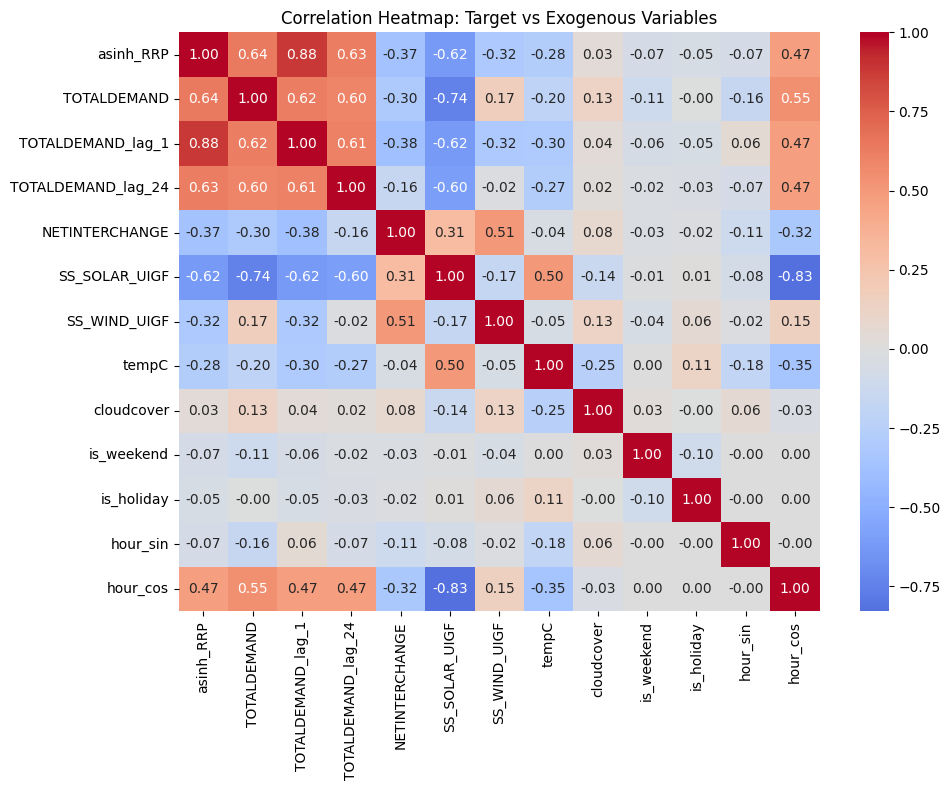

In [ ]:
# 1. Define target and exog columns
target_col = "asinh_RRP"
exog_cols = [
    "TOTALDEMAND",
    "TOTALDEMAND_lag_1",
    "TOTALDEMAND_lag_24",
    "NETINTERCHANGE",
    "SS_SOLAR_UIGF",
    "SS_WIND_UIGF",
    "tempC",
    "cloudcover",
    "is_weekend",
    "is_holiday",
    "hour_sin",
    "hour_cos",
]

# 2. Compute correlation matrix
corr_df = sa_df[[target_col] + exog_cols].copy()
corr_matrix = corr_df.corr()

# 3. Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap: Target vs Exogenous Variables")
plt.tight_layout()
plt.show()

# SARIMA

In [ ]:
# 2. Select Target Series
target = sa_df["asinh_RRP"].dropna()

In [ ]:
# 3. Define Train and Test
train = target[:"2025-02-28 23:00"]
test = target["2025-03-01 00:00":"2025-03-07 23:00"]  # 168 hourly steps

In [ ]:
# 4. Fit SARIMA Model
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)  # Daily seasonality

model = sm.tsa.SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

In [ ]:
# 5. Forecast Week Ahead
forecast = results.forecast(steps=168)

# Inverse Transform: asinh_RRP → RRP
forecast_r = np.sinh(forecast)
test_r = np.sinh(test)

In [ ]:
# 6. Evaluate
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2%}")

In [ ]:
# 7. Plot Forecast vs Actual
plt.figure(figsize=(15, 5))
plt.plot(test.index, test, label="Actual (asinh_RRP)", color="orange")
plt.plot(test.index, forecast, label="Forecast", color="green")
plt.title("SARIMA Forecast: 2025-03-01 to 2025-03-07")
plt.xlabel("Date")
plt.ylabel("asinh_RRP")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 6. Evaluate on Actual RRP
mae = mean_absolute_error(test_r, forecast_r)
mse = mean_squared_error(test_r, forecast_r)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_r, forecast_r)

print(f"MAE (RRP): {mae:.2f}")
print(f"RMSE (RRP): {rmse:.2f}")
print(f"MAPE (RRP): {mape:.2%}")

In [ ]:
# 7. Plot Forecast vs Actual (RRP)
plt.figure(figsize=(15, 5))
plt.plot(test.index, test_r, label="Actual (RRP)", color="orange")
plt.plot(test.index, forecast_r, label="Forecast (RRP)", color="green")
plt.title("SARIMA Forecast: 2025-03-01 to 2025-03-07 (RRP)")
plt.xlabel("Date")
plt.ylabel("RRP")
plt.legend()
plt.tight_layout()
plt.show()

# SARIMAX

------ SARIMAX Forecast (March 1-7) — With Exogenous Variables ------
MAE:  369.74 $/MWh
RMSE: 1199.87 $/MWh
MAPE: 231.49%


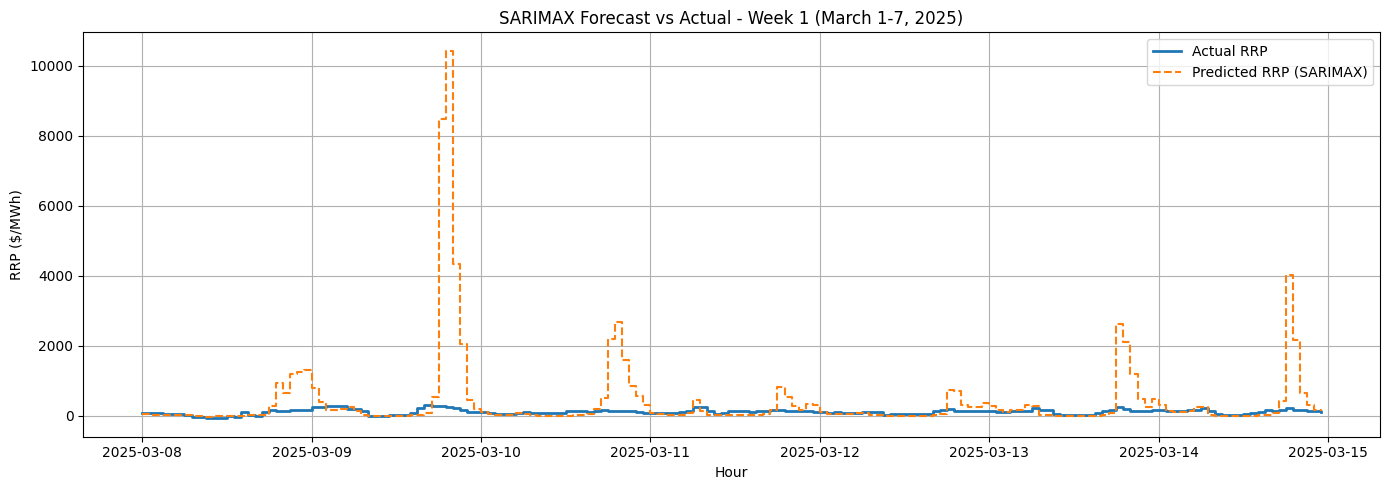

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

# Parameters
forecast_steps = 168  # 7 days of hourly forecasts
target = "asinh_RRP"
exog_cols = [
    "TOTALDEMAND",
    "NETINTERCHANGE",
    "SS_SOLAR_UIGF",
    "SS_WIND_UIGF",
    "tempC",
    "is_weekend",
    "is_holiday",
]
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)

# Load Data
df = pd.read_csv("../data/featurised/SA_final.csv", parse_dates=["SETTLEMENTDATE"])
df.set_index("SETTLEMENTDATE", inplace=True)
df = df.asfreq("h")

# Define Train and Test Periods
forecast_start = pd.Timestamp("2025-03-08 00:00")  # Update for other weeks if needed
forecast_end = forecast_start + pd.Timedelta(hours=forecast_steps - 1)

train_df = df[df.index < forecast_start]
test_df = df[(df.index >= forecast_start) & (df.index <= forecast_end)]

# Prepare Exogenous Variables
exog_train = train_df[exog_cols]
exog_test = test_df[exog_cols]

# Fit SARIMAX
model = SARIMAX(
    endog=train_df[target],
    exog=exog_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

results = model.fit(disp=True, maxiter=100)

# Forecast
forecast_asinh = results.forecast(steps=forecast_steps, exog=exog_test)

# Convert to RRP and Evaluate
y_true_asinh = test_df[target]
y_pred_asinh = forecast_asinh

y_true_rrp = np.sinh(y_true_asinh)
y_pred_rrp = np.sinh(y_pred_asinh)

# Clip extreme values
y_true_rrp = np.clip(y_true_rrp, -1000, 17500)
y_pred_rrp = np.clip(y_pred_rrp, -1000, 17500)

# Evaluation Metrics
mae = mean_absolute_error(y_true_rrp, y_pred_rrp)
rmse = np.sqrt(mean_squared_error(y_true_rrp, y_pred_rrp))
mape = mean_absolute_percentage_error(y_true_rrp, y_pred_rrp)

print("------ SARIMAX Forecast (March 1-7) — With Exogenous Variables ------")
print(f"MAE:  {mae:.2f} $/MWh")
print(f"RMSE: {rmse:.2f} $/MWh")
print(f"MAPE: {mape:.2%}")

# Plot Forecast
plt.figure(figsize=(14, 5))
plt.plot(
    y_true_rrp.index,
    y_true_rrp,
    label="Actual RRP",
    linewidth=2,
    drawstyle="steps-post",
)
plt.plot(
    y_pred_rrp.index,
    y_pred_rrp,
    label="Predicted RRP (SARIMAX)",
    linestyle="--",
    drawstyle="steps-post",
)
plt.title("SARIMAX Forecast vs Actual - Week 1 (March 1-7, 2025)")
plt.xlabel("Hour")
plt.ylabel("RRP ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing forecast for week 1...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------ SARIMAX Forecast — Week 1 (2025-03-01 to 2025-03-07) ------
MAE:  55.74 $/MWh
RMSE: 117.79 $/MWh
MAPE: 96.55%
MBE:  15.82 $/MWh



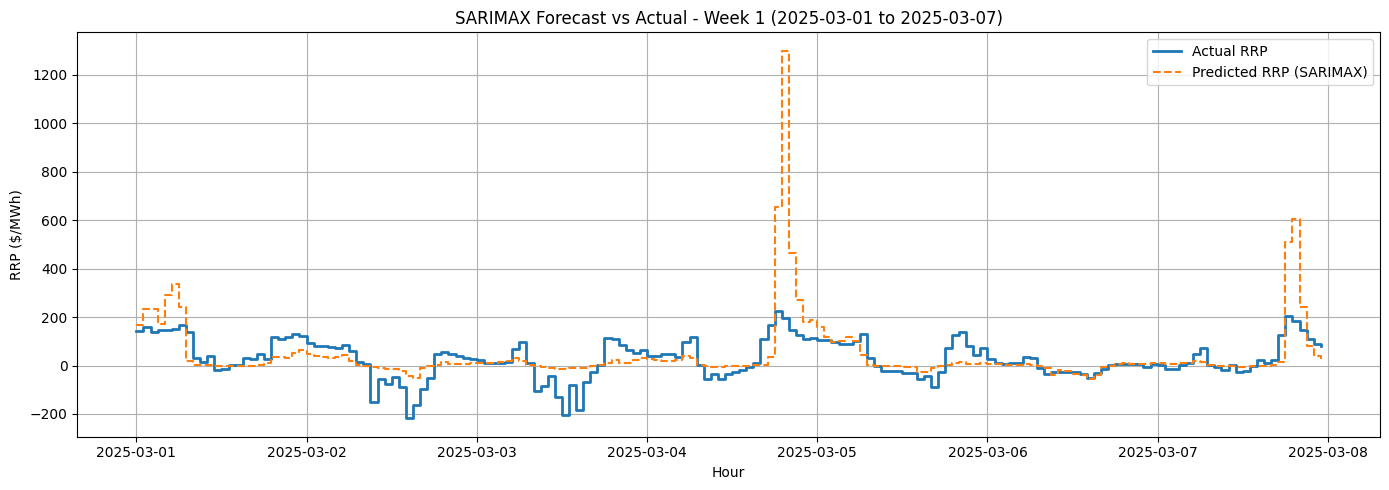

Processing forecast for week 2...
------ SARIMAX Forecast — Week 2 (2025-03-08 to 2025-03-14) ------
MAE:  369.74 $/MWh
RMSE: 1199.87 $/MWh
MAPE: 231.49%
MBE:  297.63 $/MWh



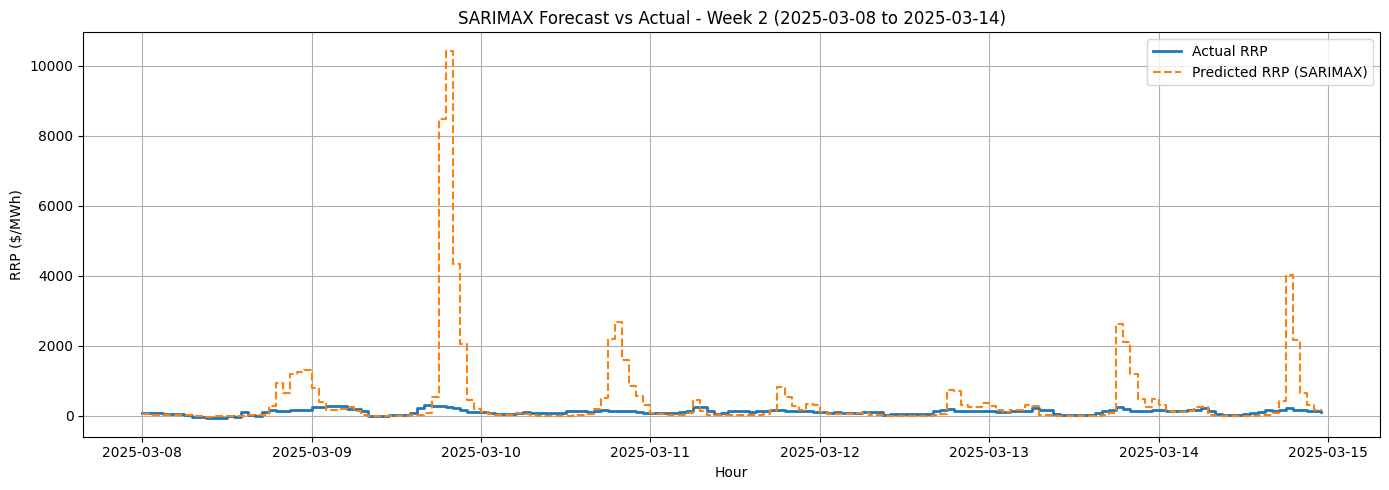

Processing forecast for week 3...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------ SARIMAX Forecast — Week 3 (2025-03-15 to 2025-03-21) ------
MAE:  159.43 $/MWh
RMSE: 375.68 $/MWh
MAPE: 148.73%
MBE:  114.39 $/MWh



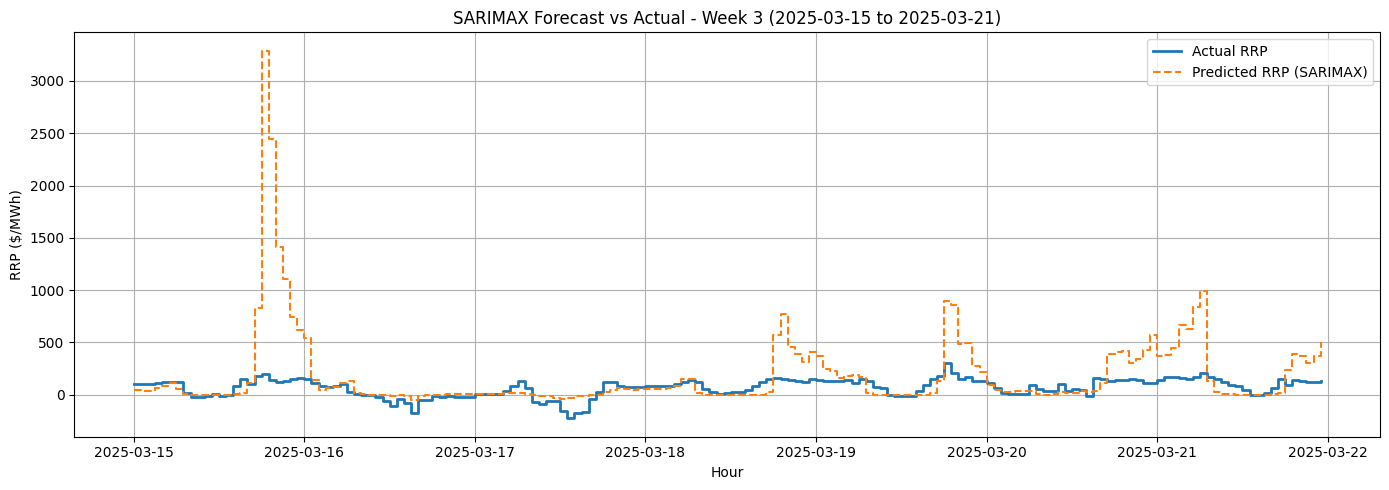

Processing forecast for week 4...
------ SARIMAX Forecast — Week 4 (2025-03-22 to 2025-03-28) ------
MAE:  59.13 $/MWh
RMSE: 92.26 $/MWh
MAPE: 81.54%
MBE:  -14.99 $/MWh



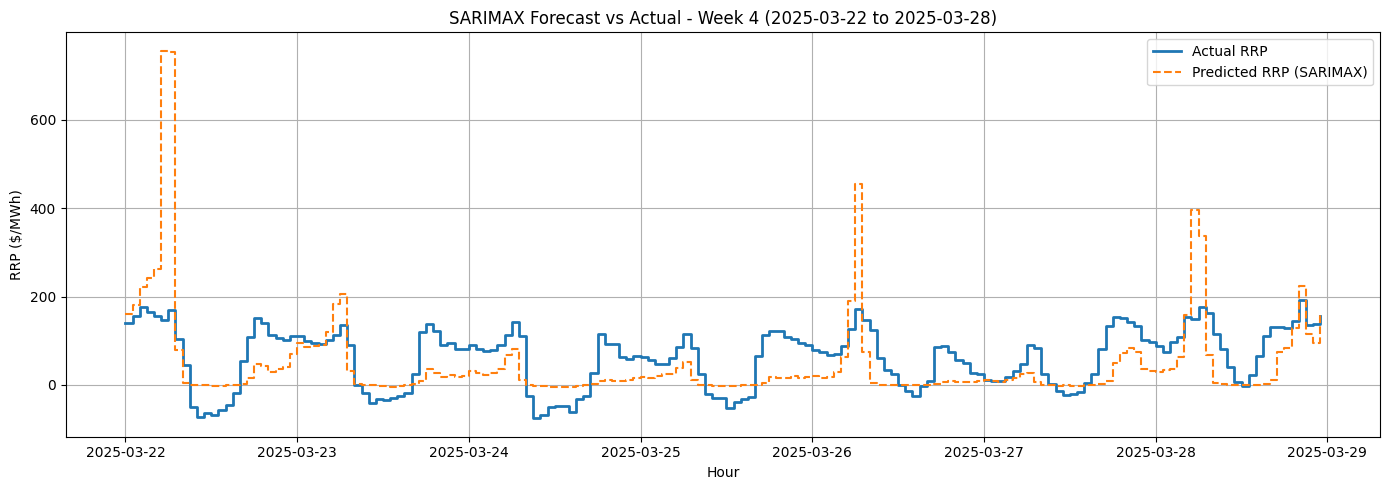

Combined forecast CSV saved to: ./sarimax_outputs\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End         MAE         RMSE    MAPE (%)  \
0  Week 1  2025-03-01  2025-03-07   55.743787   117.785724   96.551653   
1  Week 2  2025-03-08  2025-03-14  369.739375  1199.871238  231.485723   
2  Week 3  2025-03-15  2025-03-21  159.431024   375.677102  148.730919   
3  Week 4  2025-03-22  2025-03-28   59.134105    92.262612   81.540553   

          MBE  
0   15.823107  
1  297.626752  
2  114.385308  
3  -14.986667  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import os

# Parameters
forecast_steps = 168  # 7 days of hourly forecasts
target = "asinh_RRP"
exog_cols = [
    "TOTALDEMAND",
    "NETINTERCHANGE",
    "SS_SOLAR_UIGF",
    "SS_WIND_UIGF",
    "tempC",
    "is_weekend",
    "is_holiday",
]
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)

# Output paths
output_dir = "./sarimax_outputs"
forecast_csv_path = os.path.join(output_dir, "sarimax_combined_forecasts.csv")
metrics_csv_path = os.path.join(output_dir, "sarimax_weekly_metrics.csv")
os.makedirs(output_dir, exist_ok=True)

# Load Data
df = pd.read_csv("../data/featurised/SA_final.csv", parse_dates=["SETTLEMENTDATE"])
df.set_index("SETTLEMENTDATE", inplace=True)
df = df.asfreq("h")


# Mean Bias Error function
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)


# Loop over each forecast week
start_dates = [
    pd.Timestamp("2025-03-01 00:00"),
    pd.Timestamp("2025-03-08 00:00"),
    pd.Timestamp("2025-03-15 00:00"),
    pd.Timestamp("2025-03-22 00:00"),
]

combined_results = []
metrics_list = []

for i, forecast_start in enumerate(start_dates, start=1):
    print(f"Processing forecast for week {i}...")
    forecast_end = forecast_start + pd.Timedelta(hours=forecast_steps - 1)

    train_df = df[df.index < forecast_start]
    test_df = df[(df.index >= forecast_start) & (df.index <= forecast_end)]

    exog_train = train_df[exog_cols]
    exog_test = test_df[exog_cols]

    # Fit SARIMAX
    model = SARIMAX(
        endog=train_df[target],
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    results = model.fit(disp=False, maxiter=100)

    # Forecast
    forecast_asinh = results.forecast(steps=forecast_steps, exog=exog_test)

    y_true_asinh = test_df[target]
    y_pred_asinh = forecast_asinh

    y_true_rrp = np.sinh(y_true_asinh)
    y_pred_rrp = np.sinh(y_pred_asinh)

    # Clipping
    y_true_rrp = np.clip(y_true_rrp, -1000, 17500)
    y_pred_rrp = np.clip(y_pred_rrp, -1000, 17500)

    # Evaluation
    mae = mean_absolute_error(y_true_rrp, y_pred_rrp)
    rmse = np.sqrt(mean_squared_error(y_true_rrp, y_pred_rrp))
    mape = mean_absolute_percentage_error(y_true_rrp, y_pred_rrp)
    mbe = mean_bias_error(y_true_rrp, y_pred_rrp)

    print(
        f"------ SARIMAX Forecast — Week {i} ({forecast_start.date()} to {forecast_end.date()}) ------"
    )
    print(f"MAE:  {mae:.2f} $/MWh")
    print(f"RMSE: {rmse:.2f} $/MWh")
    print(f"MAPE: {mape:.2%}")
    print(f"MBE:  {mbe:.2f} $/MWh\n")

    # Save forecasts to DataFrame
    result_df = pd.DataFrame(
        {
            "datetime": y_true_rrp.index,
            "week": f"Week {i}",
            "actual_RRP": y_true_rrp.values,
            "predicted_RRP": y_pred_rrp.values,
        }
    )
    combined_results.append(result_df)

    # Log metrics
    metrics_list.append(
        {
            "Week": f"Week {i}",
            "Start": forecast_start.date(),
            "End": forecast_end.date(),
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape * 100,
            "MBE": mbe,
        }
    )

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(
        y_true_rrp.index,
        y_true_rrp,
        label="Actual RRP",
        linewidth=2,
        drawstyle="steps-post",
    )
    plt.plot(
        y_pred_rrp.index,
        y_pred_rrp,
        label="Predicted RRP (SARIMAX)",
        linestyle="--",
        drawstyle="steps-post",
    )
    plt.title(
        f"SARIMAX Forecast vs Actual - Week {i} ({forecast_start.date()} to {forecast_end.date()})"
    )
    plt.xlabel("Hour")
    plt.ylabel("RRP ($/MWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(output_dir, f"sarimax_week_{i}_forecast.png")
    plt.savefig(plot_path)
    plt.show()

# Save combined forecasts
final_df = pd.concat(combined_results)
final_df.to_csv(forecast_csv_path, index=False)
print(f"Combined forecast CSV saved to: {forecast_csv_path}")

# Save metrics table
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"Metrics summary CSV saved to: {metrics_csv_path}")
print("\nWeekly Metrics Summary:\n", metrics_df)


Processing forecast for Week 1 (VIC)...
MAE:  310.06 $/MWh
RMSE: 1600.25 $/MWh
MAPE: 363.04%
MBE:  302.39 $/MWh


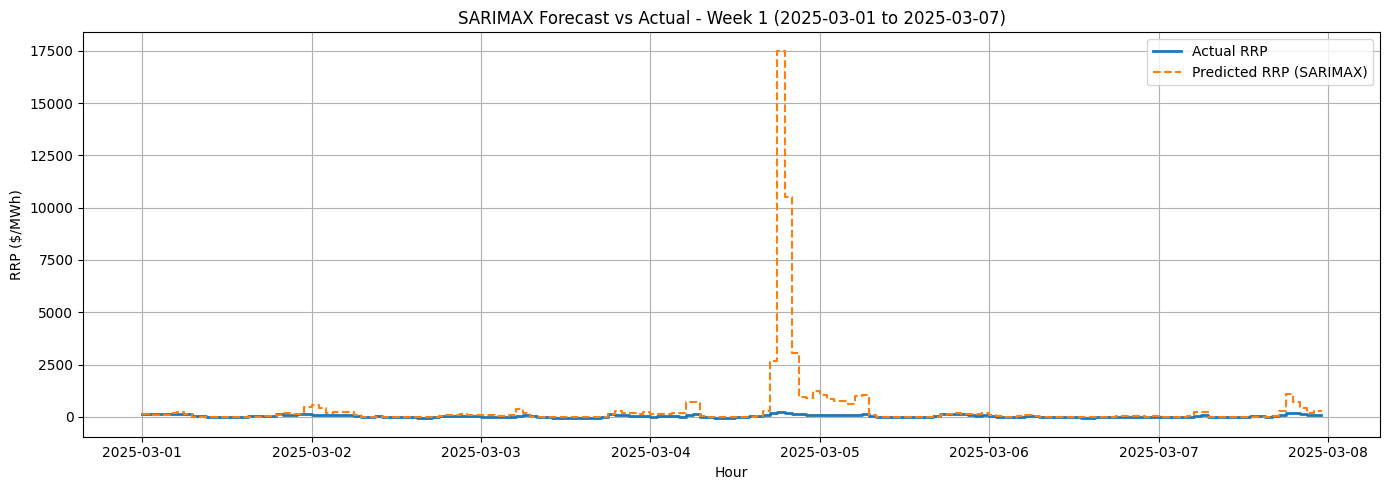


Processing forecast for Week 2 (VIC)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  461.20 $/MWh
RMSE: 1732.03 $/MWh
MAPE: 343.10%
MBE:  432.04 $/MWh


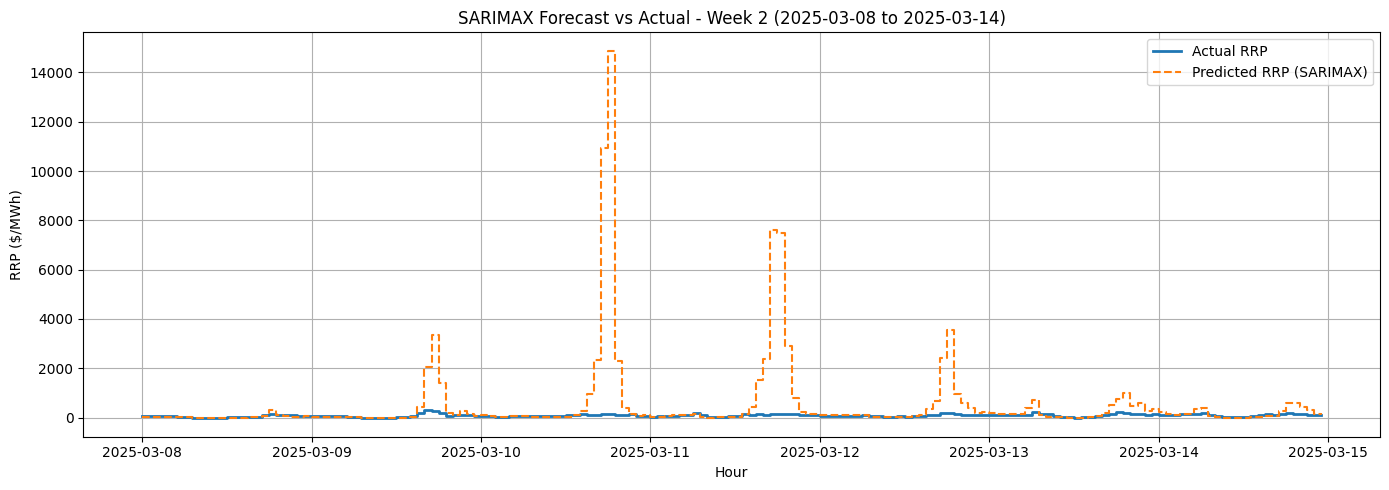


Processing forecast for Week 3 (VIC)...
MAE:  51.90 $/MWh
RMSE: 92.89 $/MWh
MAPE: 74.41%
MBE:  -13.99 $/MWh


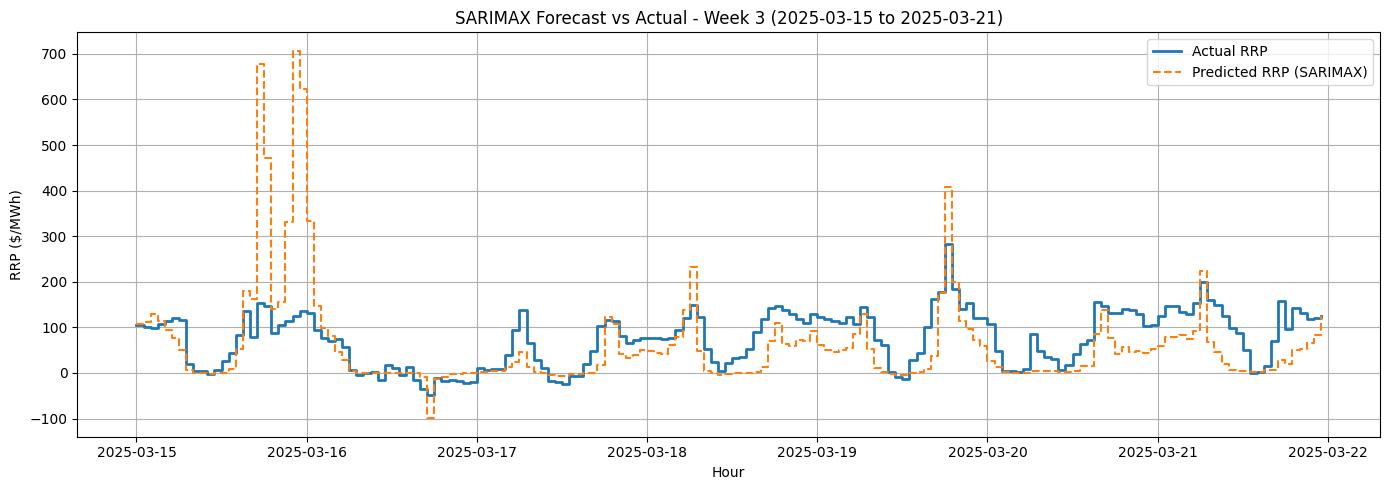


Processing forecast for Week 4 (VIC)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  42.54 $/MWh
RMSE: 57.25 $/MWh
MAPE: 68.73%
MBE:  -22.69 $/MWh


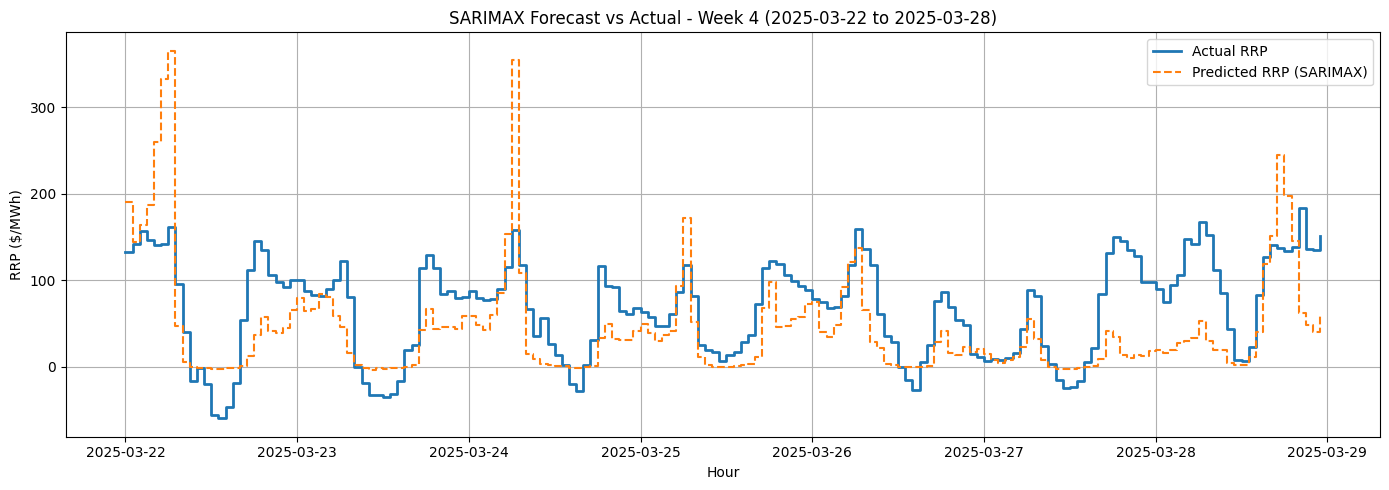


Combined forecast CSV saved to: ./sarimax_outputs/VIC\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/VIC\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End         MAE         RMSE    MAPE (%)  \
0  Week 1  2025-03-01  2025-03-07  310.058863  1600.253980  363.037932   
1  Week 2  2025-03-08  2025-03-14  461.203097  1732.031428  343.097487   
2  Week 3  2025-03-15  2025-03-21   51.898141    92.887656   74.412687   
3  Week 4  2025-03-22  2025-03-28   42.542615    57.249943   68.731294   

          MBE  
0  302.390674  
1  432.035767  
2  -13.994542  
3  -22.692778  


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

# Limit threading to avoid OpenBLAS errors
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# Parameters
forecast_steps = 168  # 7 days of hourly forecasts
target = "asinh_RRP"
exog_cols = [
    "TOTALDEMAND",
    "NETINTERCHANGE",
    "SS_SOLAR_UIGF",
    "SS_WIND_UIGF",
    "tempC",
    "is_weekend",
    "is_holiday",
]
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)


# Mean Bias Error function
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)


# SARIMAX Forecasting Pipeline
def run_sarimax_pipeline(state_abbrev: str):
    # Paths
    input_path = f"../data/featurised/{state_abbrev}_final.csv"
    output_dir = f"./sarimax_outputs/{state_abbrev}"
    forecast_csv_path = os.path.join(output_dir, f"sarimax_combined_forecasts.csv")
    metrics_csv_path = os.path.join(output_dir, f"sarimax_weekly_metrics.csv")
    os.makedirs(output_dir, exist_ok=True)

    # Load Data
    df = pd.read_csv(input_path, parse_dates=["SETTLEMENTDATE"])
    df.set_index("SETTLEMENTDATE", inplace=True)
    df = df.asfreq("h")

    start_dates = [
        pd.Timestamp("2025-03-01 00:00"),
        pd.Timestamp("2025-03-08 00:00"),
        pd.Timestamp("2025-03-15 00:00"),
        pd.Timestamp("2025-03-22 00:00"),
    ]

    combined_results = []
    metrics_list = []

    for i, forecast_start in enumerate(start_dates, start=1):
        print(f"\nProcessing forecast for Week {i} ({state_abbrev})...")
        forecast_end = forecast_start + pd.Timedelta(hours=forecast_steps - 1)

        train_df = df[df.index < forecast_start]
        test_df = df[(df.index >= forecast_start) & (df.index <= forecast_end)]

        exog_train = train_df[exog_cols]
        exog_test = test_df[exog_cols]

        # Fit SARIMAX
        model = SARIMAX(
            endog=train_df[target],
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=False, maxiter=100)

        # Forecast
        forecast_asinh = results.forecast(steps=forecast_steps, exog=exog_test)
        y_true_asinh = test_df[target]
        y_pred_asinh = forecast_asinh

        y_true_rrp = np.sinh(y_true_asinh)
        y_pred_rrp = np.sinh(y_pred_asinh)

        # Clipping
        y_true_rrp = np.clip(y_true_rrp, -1000, 17500)
        y_pred_rrp = np.clip(y_pred_rrp, -1000, 17500)

        # Evaluation
        mae = mean_absolute_error(y_true_rrp, y_pred_rrp)
        rmse = np.sqrt(mean_squared_error(y_true_rrp, y_pred_rrp))
        mape = mean_absolute_percentage_error(y_true_rrp, y_pred_rrp)
        mbe = mean_bias_error(y_true_rrp, y_pred_rrp)

        print(f"MAE:  {mae:.2f} $/MWh")
        print(f"RMSE: {rmse:.2f} $/MWh")
        print(f"MAPE: {mape:.2%}")
        print(f"MBE:  {mbe:.2f} $/MWh")

        # Save forecasts
        result_df = pd.DataFrame(
            {
                "datetime": y_true_rrp.index,
                "week": f"Week {i}",
                "actual_RRP": y_true_rrp.values,
                "predicted_RRP": y_pred_rrp.values,
            }
        )
        combined_results.append(result_df)

        # Log metrics
        metrics_list.append(
            {
                "Week": f"Week {i}",
                "Start": forecast_start.date(),
                "End": forecast_end.date(),
                "MAE": mae,
                "RMSE": rmse,
                "MAPE (%)": mape * 100,
                "MBE": mbe,
            }
        )

        # Plot
        plt.figure(figsize=(14, 5))
        plt.plot(
            y_true_rrp.index,
            y_true_rrp,
            label="Actual RRP",
            linewidth=2,
            drawstyle="steps-post",
        )
        plt.plot(
            y_pred_rrp.index,
            y_pred_rrp,
            label="Predicted RRP (SARIMAX)",
            linestyle="--",
            drawstyle="steps-post",
        )
        plt.title(
            f"SARIMAX Forecast vs Actual - Week {i} ({forecast_start.date()} to {forecast_end.date()})"
        )
        plt.xlabel("Hour")
        plt.ylabel("RRP ($/MWh)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plot_path = os.path.join(output_dir, f"sarimax_week_{i}_forecast.png")
        plt.savefig(plot_path)
        plt.show()
        plt.close()

    # Save results
    final_df = pd.concat(combined_results)
    final_df.to_csv(forecast_csv_path, index=False)
    print(f"\nCombined forecast CSV saved to: {forecast_csv_path}")

    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.to_csv(metrics_csv_path, index=False)
    print(f"Metrics summary CSV saved to: {metrics_csv_path}")
    print("\nWeekly Metrics Summary:\n", metrics_df)


# Run for specific state
if __name__ == "__main__":
    run_sarimax_pipeline("VIC")

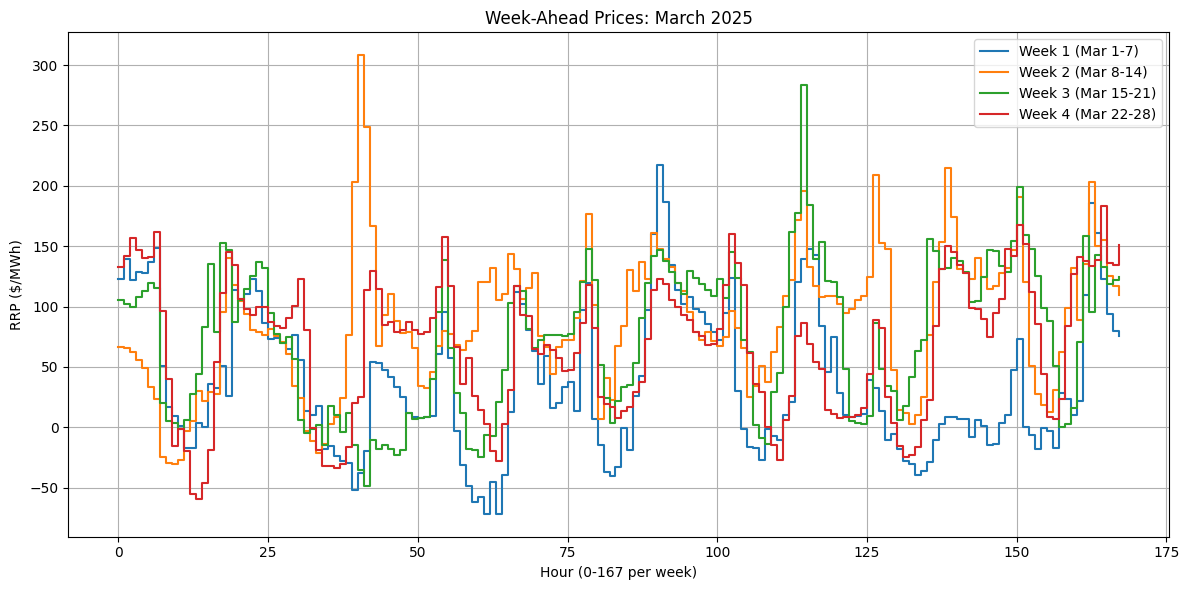

In [47]:
state = "VIC"
df = pd.read_csv(
    f"../data/featurised/{state}_final.csv", parse_dates=["SETTLEMENTDATE"]
)
df.set_index("SETTLEMENTDATE", inplace=True)
df.index = pd.to_datetime(df.index)

# Define week ranges manually for March 2025 (week starting on Saturday for AEMO data)
weeks = {
    "Week 1 (Mar 1-7)": ("2025-03-01", "2025-03-07 23:59"),
    "Week 2 (Mar 8-14)": ("2025-03-08", "2025-03-14 23:59"),
    "Week 3 (Mar 15-21)": ("2025-03-15", "2025-03-21 23:59"),
    "Week 4 (Mar 22-28)": ("2025-03-22", "2025-03-28 23:59"),
}

plt.figure(figsize=(12, 6))

for label, (start, end) in weeks.items():
    week_data = df.loc[start:end]
    hours = range(len(week_data))
    plt.plot(hours, week_data["RRP"], label=label, drawstyle="steps-post")

plt.title("Week-Ahead Prices: March 2025")
plt.xlabel("Hour (0-167 per week)")
plt.ylabel("RRP ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

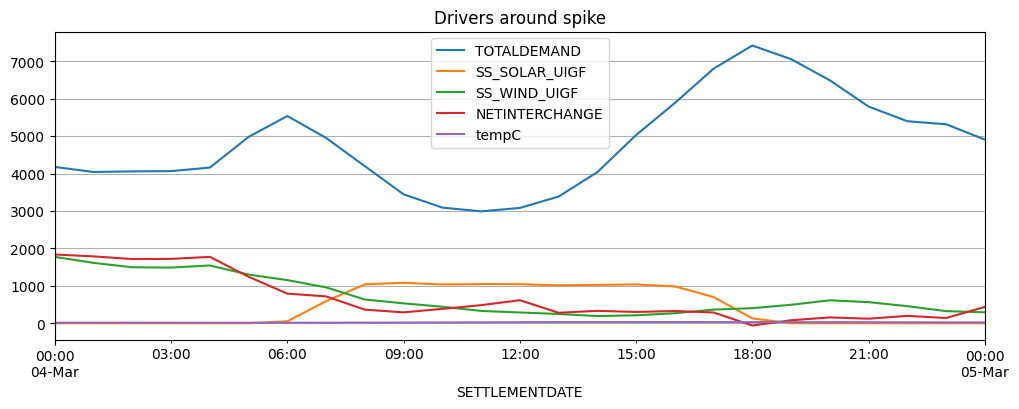

In [53]:
plot_window = df[(df.index >= "2025-03-04") & (df.index <= "2025-03-05")]

plot_window[
    ["TOTALDEMAND", "SS_SOLAR_UIGF", "SS_WIND_UIGF", "NETINTERCHANGE", "tempC"]
].plot(figsize=(12, 4), title="Drivers around spike")
plt.grid(True)
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
)

# Parameters
forecast_steps = 168  # 7 days of hourly forecasts
target = "asinh_RRP"
exog_cols = [
    "TOTALDEMAND",
    "NETINTERCHANGE",
    "SS_SOLAR_UIGF",
    "SS_WIND_UIGF",
    "tempC",
]
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)


# Custom Metrics
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)


def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon)
    )


def rmae(y_true, y_pred, naive_forecast):
    return mean_absolute_error(y_true, y_pred) / mean_absolute_error(
        y_true, naive_forecast
    )


# SARIMAX Forecasting Pipeline
def run_sarimax_pipeline(state_abbrev: str):
    # Paths
    input_path = f"../data/featurised/{state_abbrev}_test_final.csv"
    output_dir = f"./sarimax_outputs/{state_abbrev}_asinh_RRP"
    forecast_csv_path = os.path.join(output_dir, f"sarimax_combined_forecasts.csv")
    metrics_csv_path = os.path.join(output_dir, f"sarimax_weekly_metrics.csv")
    os.makedirs(output_dir, exist_ok=True)

    # Load Data
    df = pd.read_csv(input_path, parse_dates=["SETTLEMENTDATE"])
    df.set_index("SETTLEMENTDATE", inplace=True)
    df = df.asfreq("h")
    rrp_median = df["rrp_median"].values[0]
    rrp_mad = df["rrp_mad"].values[0]

    start_dates = [
        pd.Timestamp("2025-03-01 00:00"),
        pd.Timestamp("2025-03-08 00:00"),
        pd.Timestamp("2025-03-15 00:00"),
        pd.Timestamp("2025-03-22 00:00"),
    ]

    combined_results = []
    metrics_list = []

    for i, forecast_start in enumerate(start_dates, start=1):
        print(f"\nProcessing forecast for Week {i} ({state_abbrev})...")
        forecast_end = forecast_start + pd.Timedelta(hours=forecast_steps - 1)

        train_df = df[df.index < forecast_start]
        test_df = df[(df.index >= forecast_start) & (df.index <= forecast_end)]

        exog_train = train_df[exog_cols]
        exog_test = test_df[exog_cols]

        # Fit SARIMAX
        model = SARIMAX(
            endog=train_df[target],
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=False, maxiter=100)

        # Forecast
        forecast_rrp = results.forecast(steps=forecast_steps, exog=exog_test)
        y_true_rrp = np.sinh(test_df[target]) * rrp_mad + rrp_median
        y_pred_rrp = np.sinh(forecast_rrp) * rrp_mad + rrp_median

        # Clipping
        y_pred_rrp = np.clip(y_pred_rrp, -1000, 17500)

        naive_forecast = (
            np.sinh(train_df[target].iloc[-168:].values) * rrp_mad + rrp_median
        )  # Last 168 hours of training data

        # Evaluation
        mae = mean_absolute_error(y_true_rrp, y_pred_rrp)
        naive_mae = mean_absolute_error(y_true_rrp, naive_forecast)
        rel_mae = rmae(y_true_rrp, y_pred_rrp, naive_forecast)
        rmse = root_mean_squared_error(y_true_rrp, y_pred_rrp)
        smape = symmetric_mean_absolute_percentage_error(y_true_rrp, y_pred_rrp)
        mbe = mean_bias_error(y_true_rrp, y_pred_rrp)

        print(f"MAE:  {mae:.2f} $/MWh")
        print(f"Naive MAE: {naive_mae:.2f} $/MWh")
        print(f"RMAE: {rel_mae:.2f}")
        print(f"RMSE: {rmse:.2f} $/MWh")
        print(f"SMAPE: {smape:.2%}")
        print(f"MBE:  {mbe:.2f} $/MWh")

        # Save forecasts
        result_df = pd.DataFrame(
            {
                "ds": y_true_rrp.index,
                "y": y_true_rrp.values,
                "SARIMAX": y_pred_rrp.values,
                "week": f"Week {i}",
            }
        )
        combined_results.append(result_df)

        # Log metrics
        metrics_list.append(
            {
                "Week": f"Week {i}",
                "Start": forecast_start.date(),
                "End": forecast_end.date(),
                "MAE": mae,
                "rMAE": rel_mae,
                "RMSE": rmse,
                "SMAPE": smape,
                "MBE": mbe,
            }
        )

        # Plot
        plt.figure(figsize=(14, 5))
        plt.plot(
            y_true_rrp.index,
            y_true_rrp,
            label="Actual RRP",
            linewidth=2,
            drawstyle="steps-post",
        )
        plt.plot(
            y_pred_rrp.index,
            y_pred_rrp,
            label="Predicted RRP (SARIMAX)",
            linestyle="--",
            drawstyle="steps-post",
        )
        plt.title(
            f"SARIMAX Forecast vs Actual ({state_abbrev}) - Week {i} ({forecast_start.date()} to {forecast_end.date()})"
        )
        plt.xlabel("Datetime (Hourly Intervals)")
        plt.ylabel("RRP ($/MWh)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plot_path = os.path.join(output_dir, f"sarimax_week_{i}_forecast.png")
        plt.savefig(plot_path)
        plt.show()
        plt.close()

    # Save results
    final_df = pd.concat(combined_results)
    final_df.to_csv(forecast_csv_path, index=False)
    print(f"\nCombined forecast CSV saved to: {forecast_csv_path}")

    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.to_csv(metrics_csv_path, index=False)
    print(f"Metrics summary CSV saved to: {metrics_csv_path}")
    print("\nWeekly Metrics Summary:\n", metrics_df)


Processing forecast for Week 1 (VIC)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  35.14 $/MWh
Naive MAE: 58.32 $/MWh
RMAE: 0.60
RMSE: 40.96 $/MWh
SMAPE: 89.79%
MBE:  28.64 $/MWh


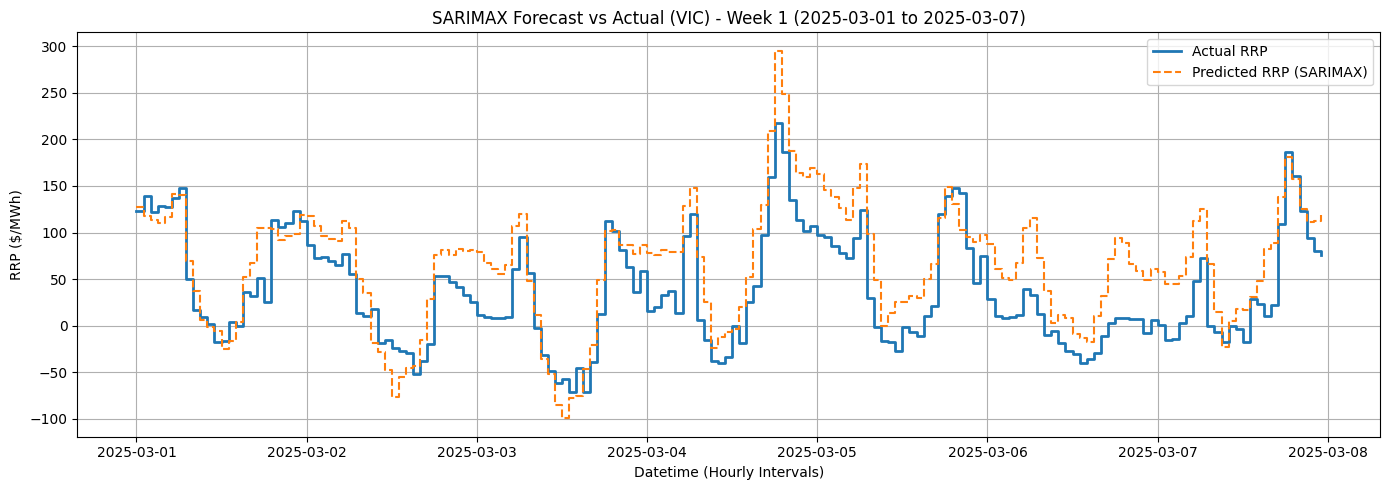


Processing forecast for Week 2 (VIC)...
MAE:  32.61 $/MWh
Naive MAE: 65.95 $/MWh
RMAE: 0.49
RMSE: 42.19 $/MWh
SMAPE: 51.61%
MBE:  -22.50 $/MWh


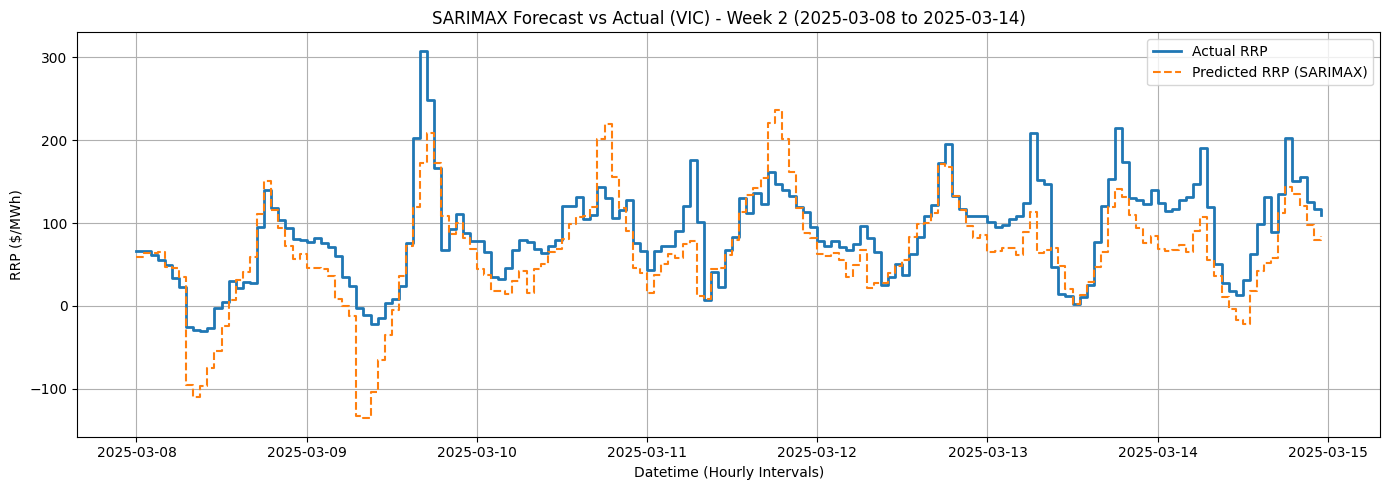


Processing forecast for Week 3 (VIC)...
MAE:  33.70 $/MWh
Naive MAE: 46.74 $/MWh
RMAE: 0.72
RMSE: 41.42 $/MWh
SMAPE: 71.82%
MBE:  -27.67 $/MWh


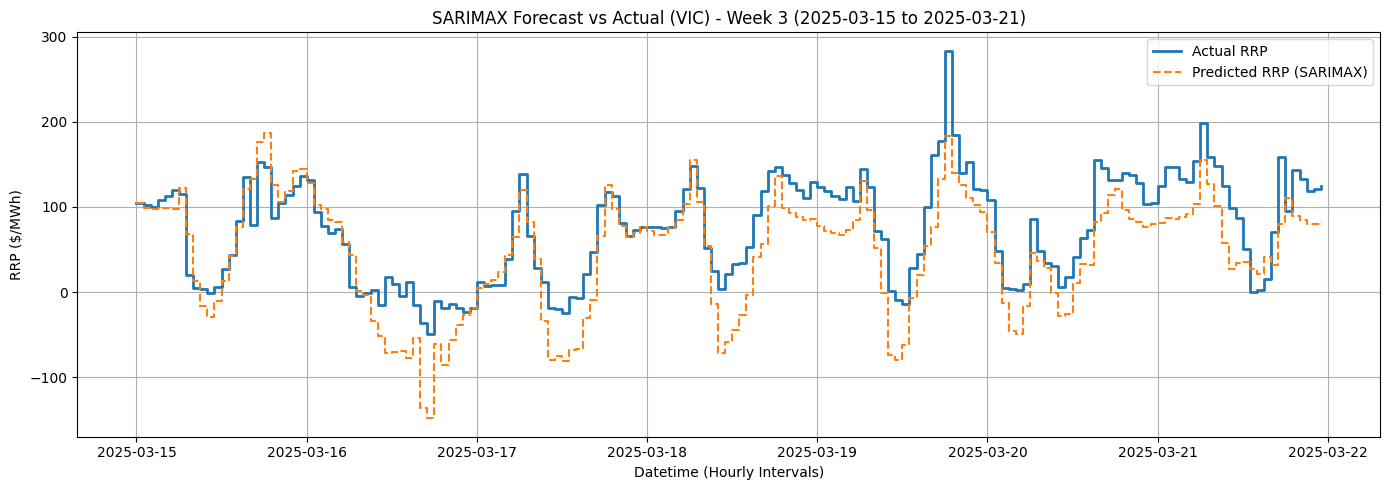


Processing forecast for Week 4 (VIC)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  22.66 $/MWh
Naive MAE: 43.67 $/MWh
RMAE: 0.52
RMSE: 28.37 $/MWh
SMAPE: 48.54%
MBE:  16.86 $/MWh


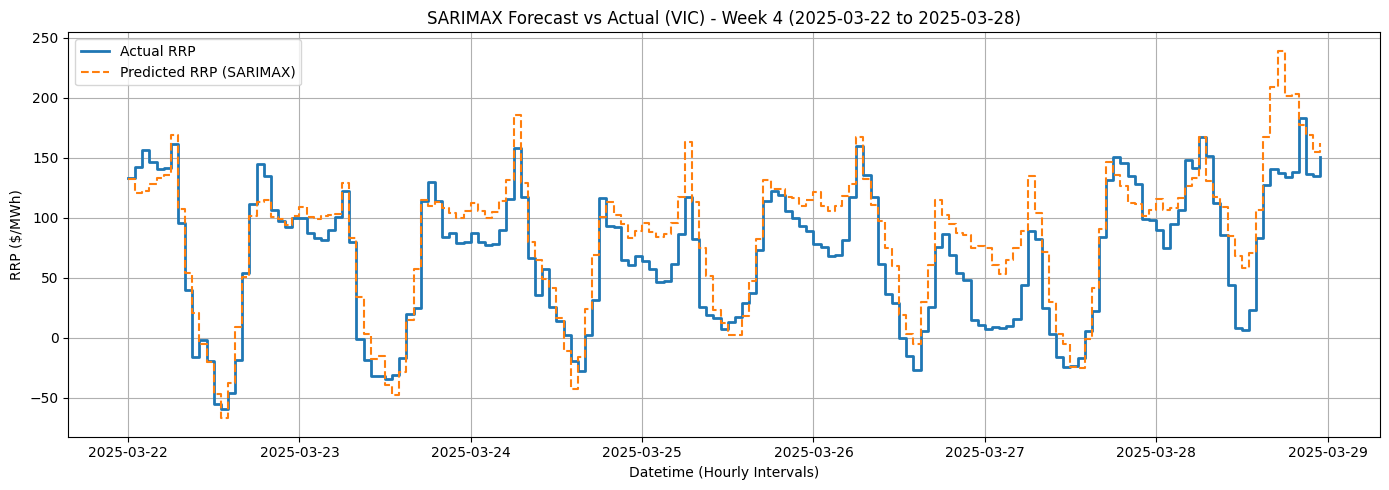


Combined forecast CSV saved to: ./sarimax_outputs/VIC_asinh_RRP\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/VIC_asinh_RRP\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End        MAE      rMAE       RMSE     SMAPE  \
0  Week 1  2025-03-01  2025-03-07  35.135769  0.602435  40.959987  0.897892   
1  Week 2  2025-03-08  2025-03-14  32.613194  0.494490  42.193385  0.516125   
2  Week 3  2025-03-15  2025-03-21  33.704694  0.721155  41.415123  0.718151   
3  Week 4  2025-03-22  2025-03-28  22.660847  0.518948  28.367327  0.485393   

         MBE  
0  28.638317  
1 -22.500262  
2 -27.671637  
3  16.859486  

Processing forecast for Week 1 (NSW)...
MAE:  39.97 $/MWh
Naive MAE: 37.34 $/MWh
RMAE: 1.07
RMSE: 50.05 $/MWh
SMAPE: 83.30%
MBE:  -36.76 $/MWh


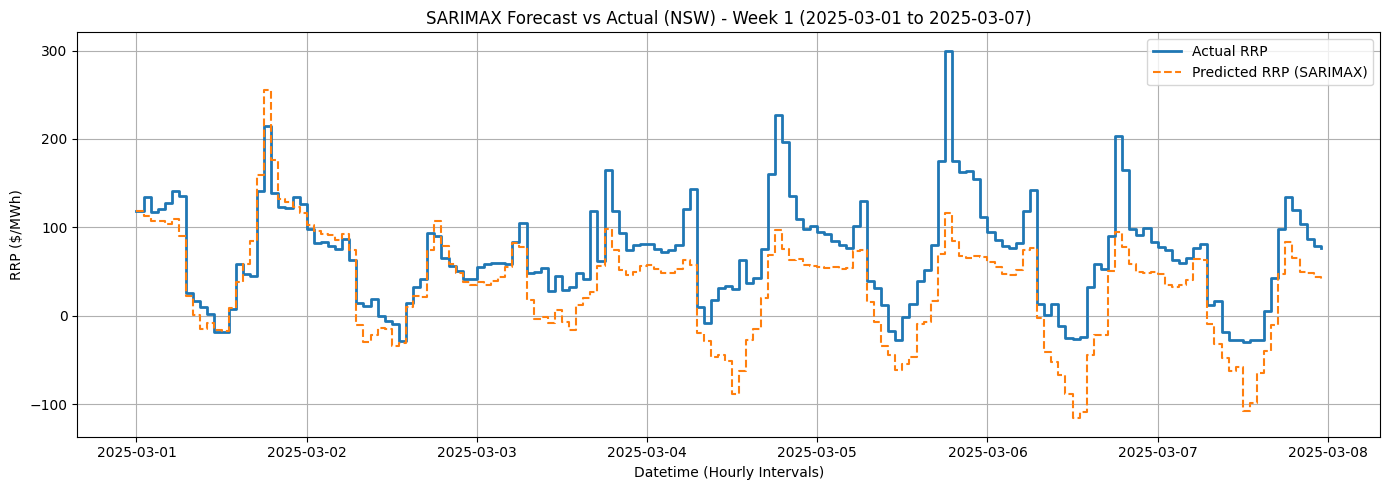


Processing forecast for Week 2 (NSW)...
MAE:  38.01 $/MWh
Naive MAE: 46.15 $/MWh
RMAE: 0.82
RMSE: 105.63 $/MWh
SMAPE: 52.32%
MBE:  -20.63 $/MWh


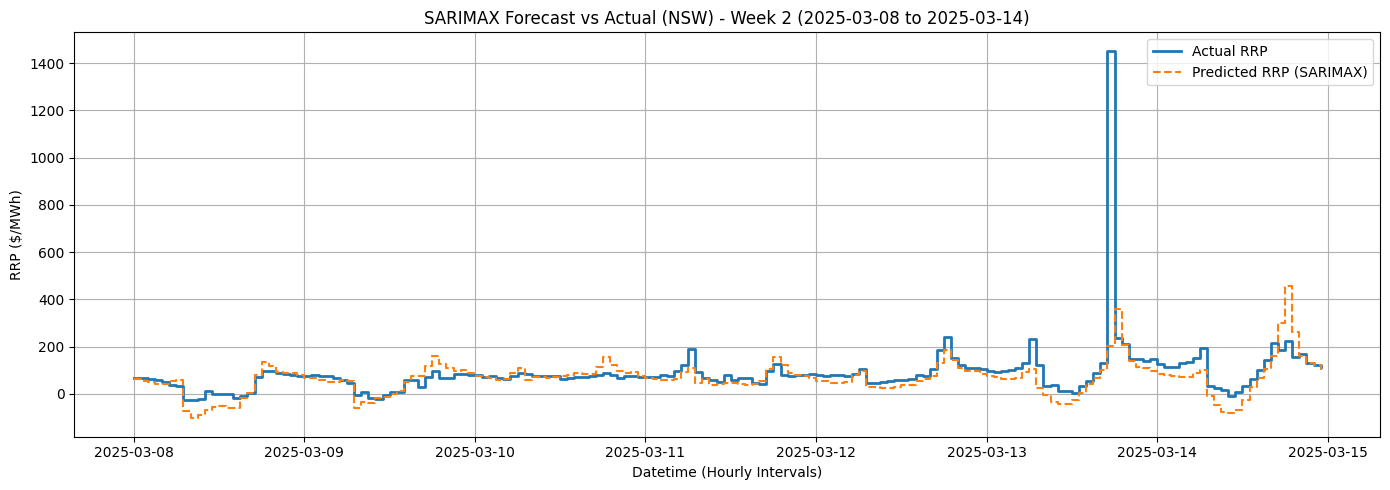


Processing forecast for Week 3 (NSW)...
MAE:  131.51 $/MWh
Naive MAE: 85.81 $/MWh
RMAE: 1.53
RMSE: 342.02 $/MWh
SMAPE: 126.62%
MBE:  -122.88 $/MWh


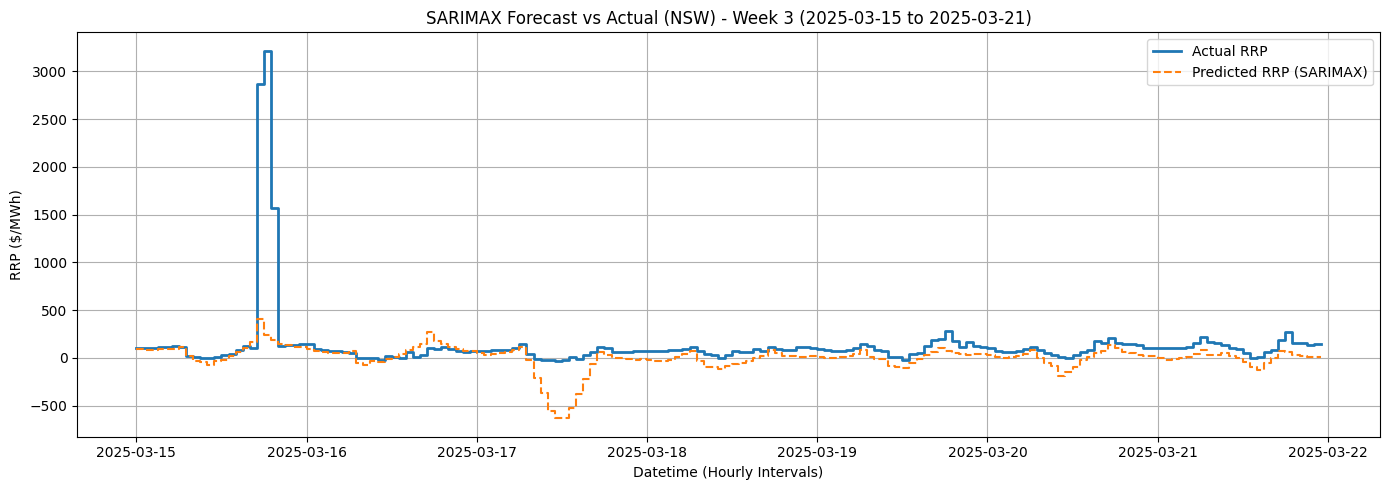


Processing forecast for Week 4 (NSW)...
MAE:  39.74 $/MWh
Naive MAE: 81.38 $/MWh
RMAE: 0.49
RMSE: 47.41 $/MWh
SMAPE: 42.46%
MBE:  28.77 $/MWh


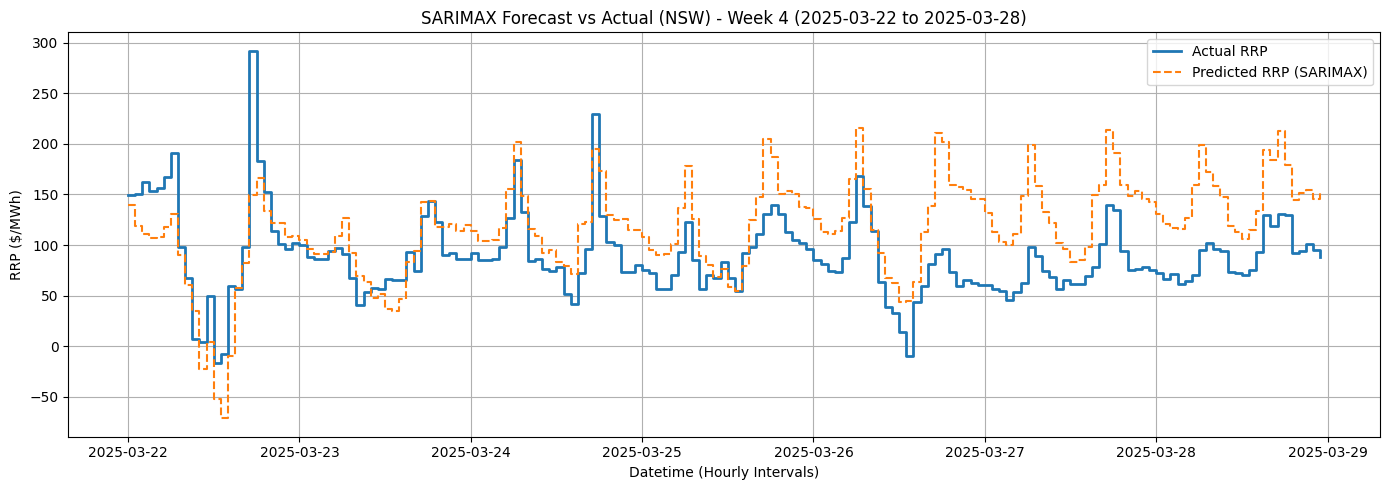


Combined forecast CSV saved to: ./sarimax_outputs/NSW_asinh_RRP\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/NSW_asinh_RRP\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End         MAE      rMAE        RMSE     SMAPE  \
0  Week 1  2025-03-01  2025-03-07   39.967902  1.070385   50.051661  0.833041   
1  Week 2  2025-03-08  2025-03-14   38.005287  0.823495  105.625876  0.523188   
2  Week 3  2025-03-15  2025-03-21  131.509456  1.532650  342.024239  1.266249   
3  Week 4  2025-03-22  2025-03-28   39.736593  0.488261   47.407725  0.424592   

          MBE  
0  -36.763255  
1  -20.627347  
2 -122.876272  
3   28.769520  

Processing forecast for Week 1 (QLD)...
MAE:  31.79 $/MWh
Naive MAE: 28.41 $/MWh
RMAE: 1.12
RMSE: 39.61 $/MWh
SMAPE: 56.18%
MBE:  27.08 $/MWh


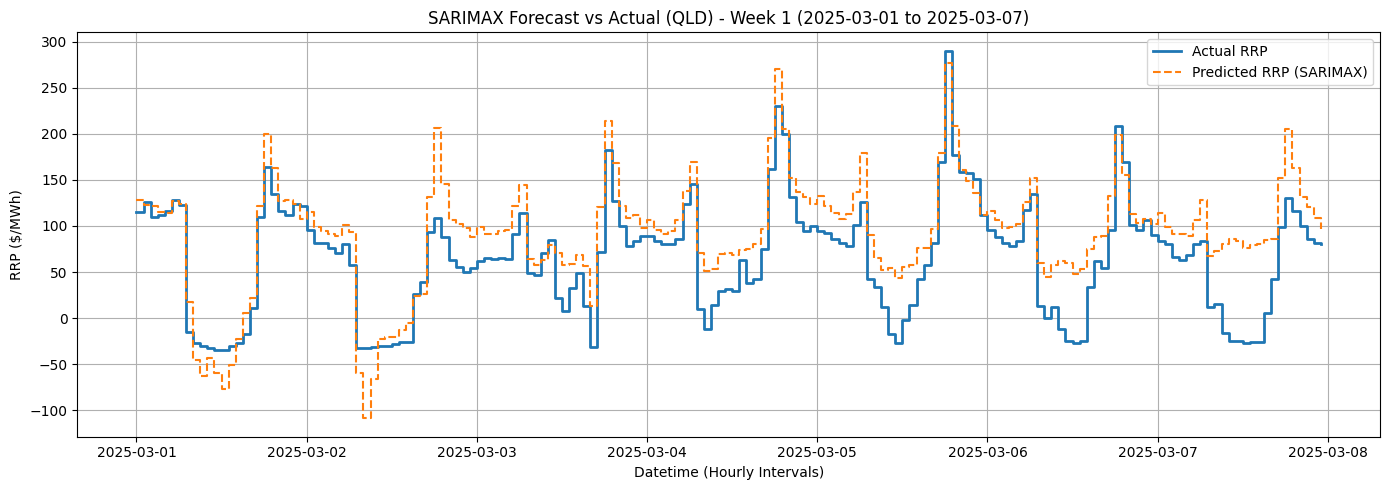


Processing forecast for Week 2 (QLD)...
MAE:  45.27 $/MWh
Naive MAE: 35.86 $/MWh
RMAE: 1.26
RMSE: 104.19 $/MWh
SMAPE: 71.52%
MBE:  -36.02 $/MWh


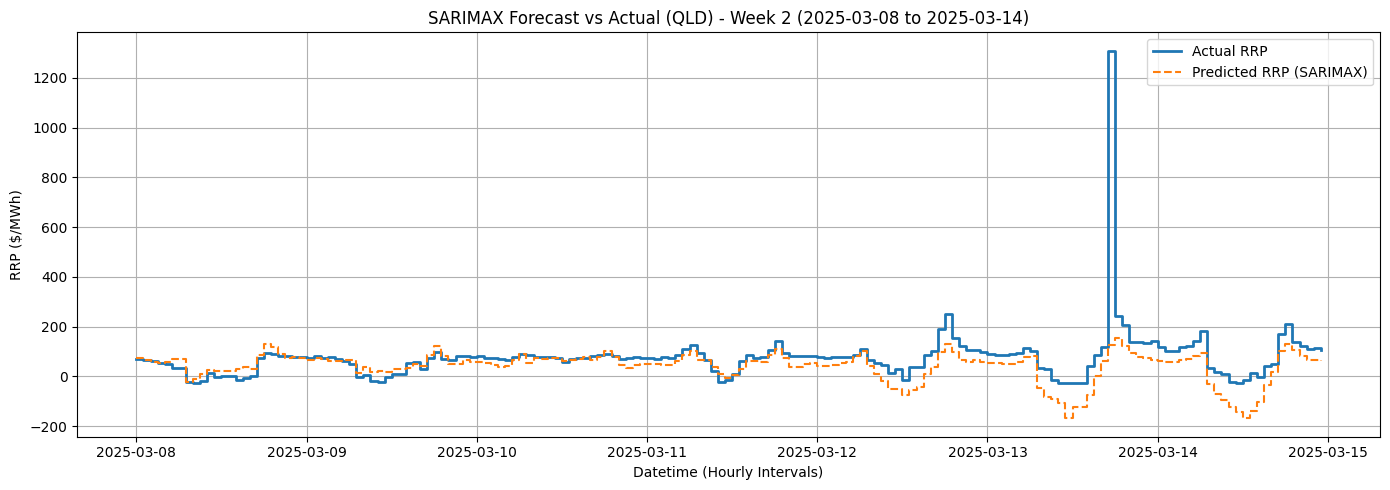


Processing forecast for Week 3 (QLD)...
MAE:  28.71 $/MWh
Naive MAE: 36.36 $/MWh
RMAE: 0.79
RMSE: 39.71 $/MWh
SMAPE: 48.52%
MBE:  -14.27 $/MWh


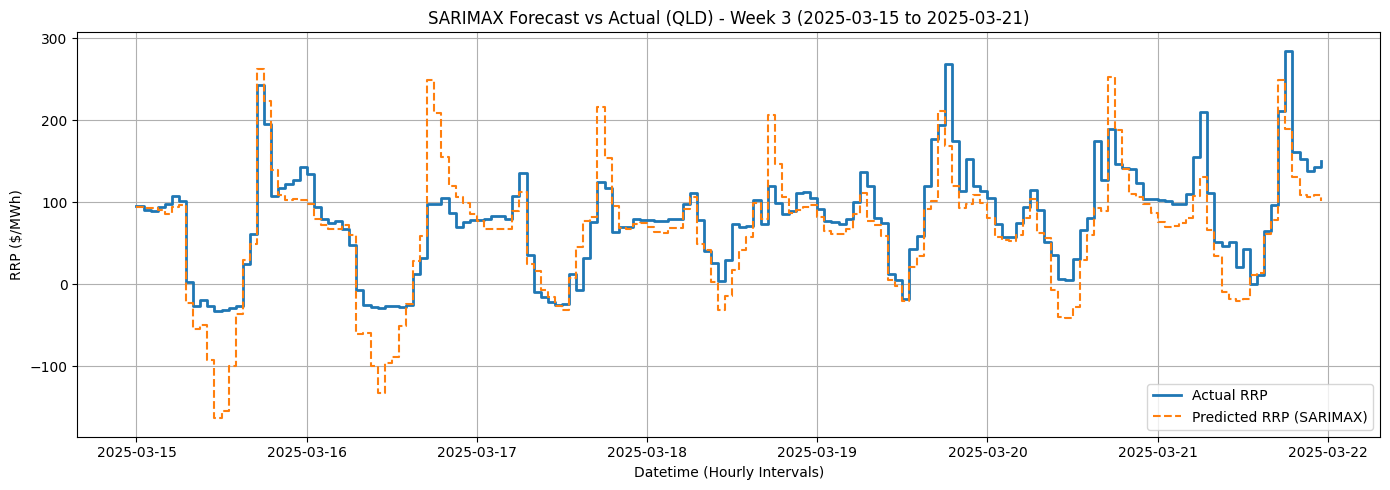


Processing forecast for Week 4 (QLD)...
MAE:  31.65 $/MWh
Naive MAE: 42.57 $/MWh
RMAE: 0.74
RMSE: 36.81 $/MWh
SMAPE: 33.95%
MBE:  29.15 $/MWh


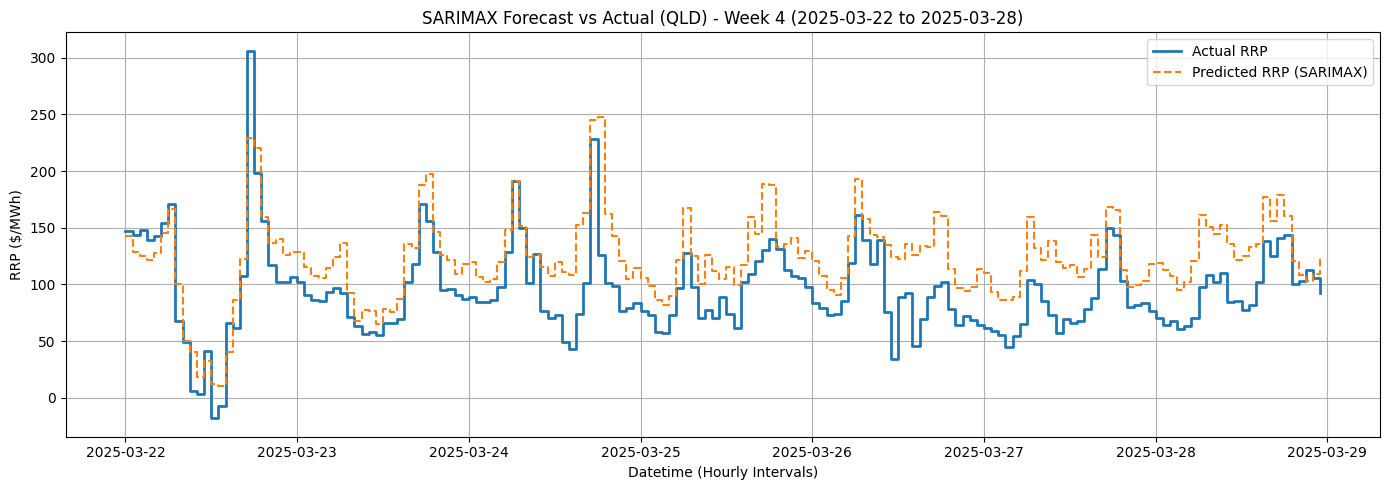


Combined forecast CSV saved to: ./sarimax_outputs/QLD_asinh_RRP\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/QLD_asinh_RRP\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End        MAE      rMAE        RMSE     SMAPE  \
0  Week 1  2025-03-01  2025-03-07  31.792484  1.118874   39.610739  0.561795   
1  Week 2  2025-03-08  2025-03-14  45.266693  1.262345  104.190595  0.715168   
2  Week 3  2025-03-15  2025-03-21  28.710449  0.789663   39.706924  0.485227   
3  Week 4  2025-03-22  2025-03-28  31.650375  0.743509   36.810737  0.339518   

         MBE  
0  27.076696  
1 -36.023194  
2 -14.267128  
3  29.147341  

Processing forecast for Week 1 (SA)...
MAE:  30.49 $/MWh
Naive MAE: 74.22 $/MWh
RMAE: 0.41
RMSE: 44.54 $/MWh
SMAPE: 64.07%
MBE:  -0.62 $/MWh


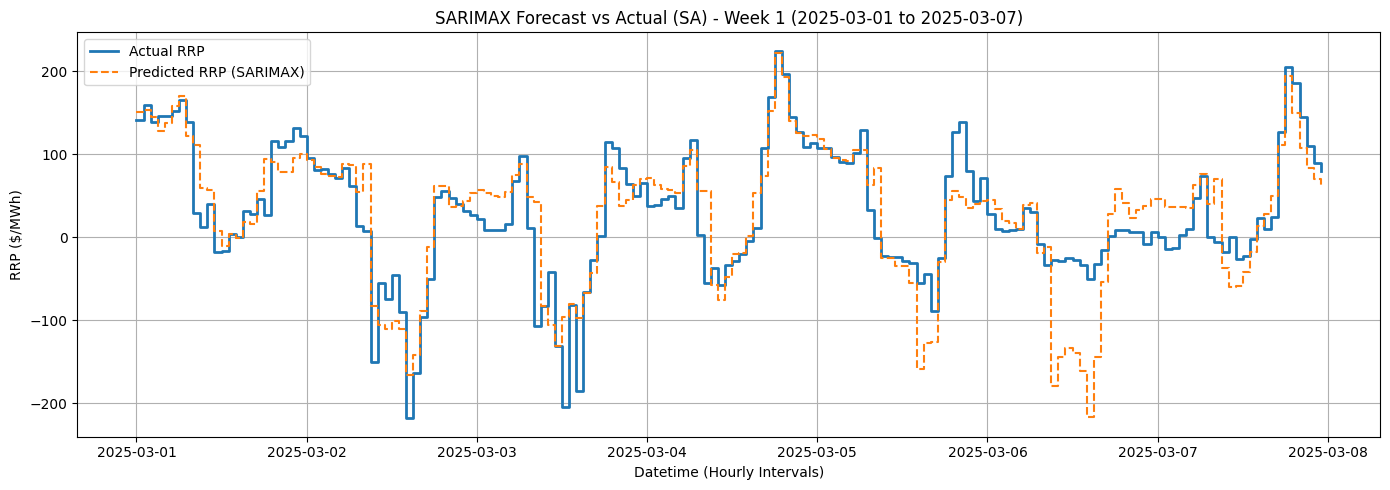


Processing forecast for Week 2 (SA)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  32.87 $/MWh
Naive MAE: 96.47 $/MWh
RMAE: 0.34
RMSE: 44.52 $/MWh
SMAPE: 38.37%
MBE:  -2.52 $/MWh


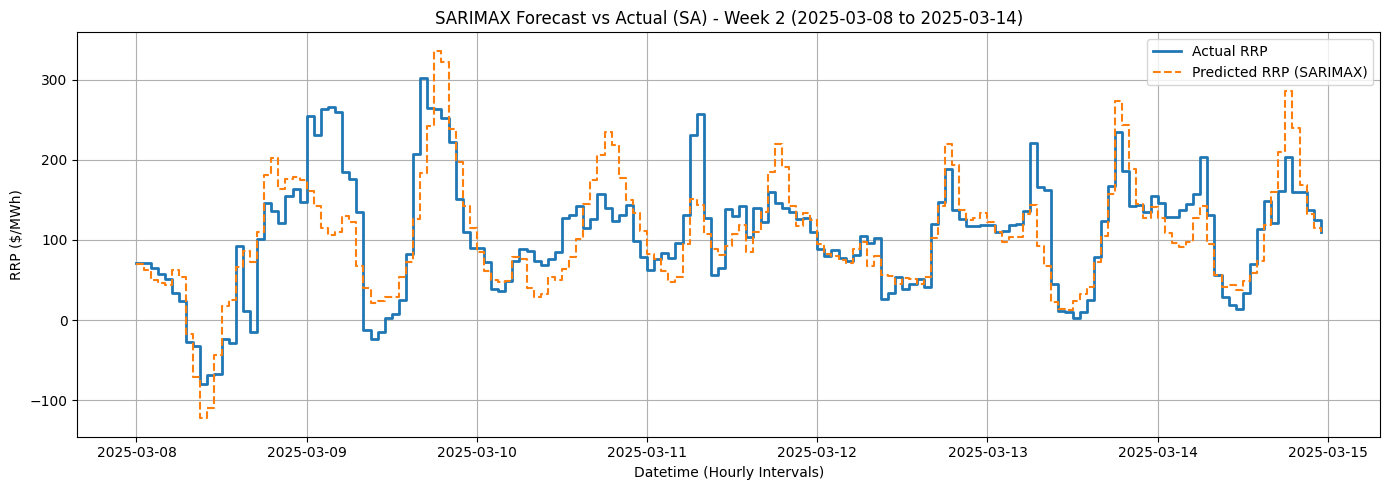


Processing forecast for Week 3 (SA)...
MAE:  29.20 $/MWh
Naive MAE: 71.98 $/MWh
RMAE: 0.41
RMSE: 39.55 $/MWh
SMAPE: 54.01%
MBE:  -3.56 $/MWh


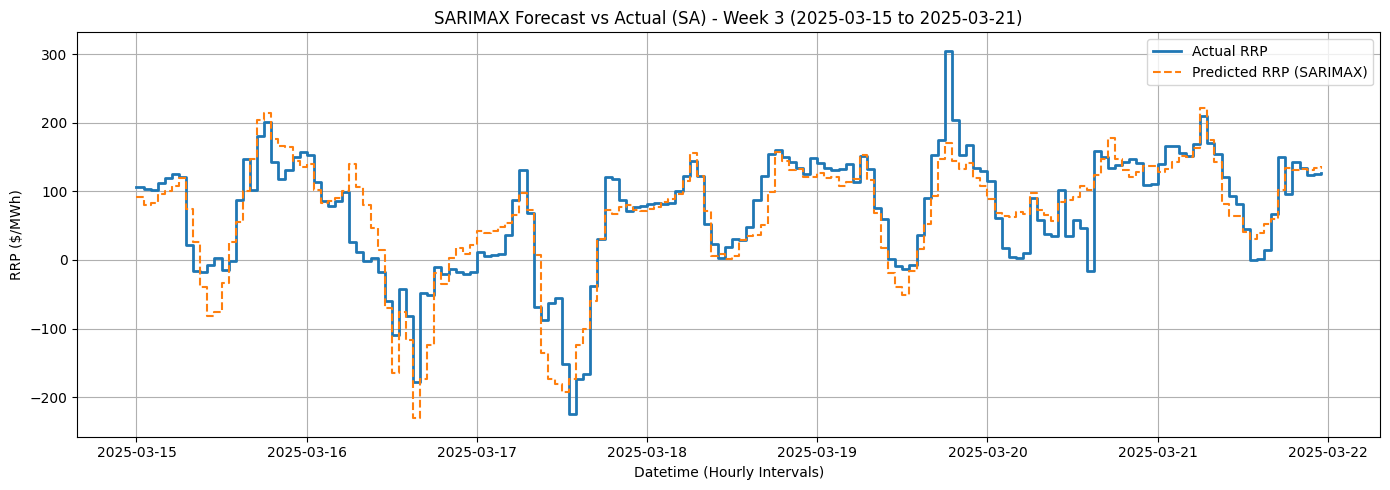


Processing forecast for Week 4 (SA)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  26.25 $/MWh
Naive MAE: 51.79 $/MWh
RMAE: 0.51
RMSE: 31.49 $/MWh
SMAPE: 51.82%
MBE:  -16.38 $/MWh


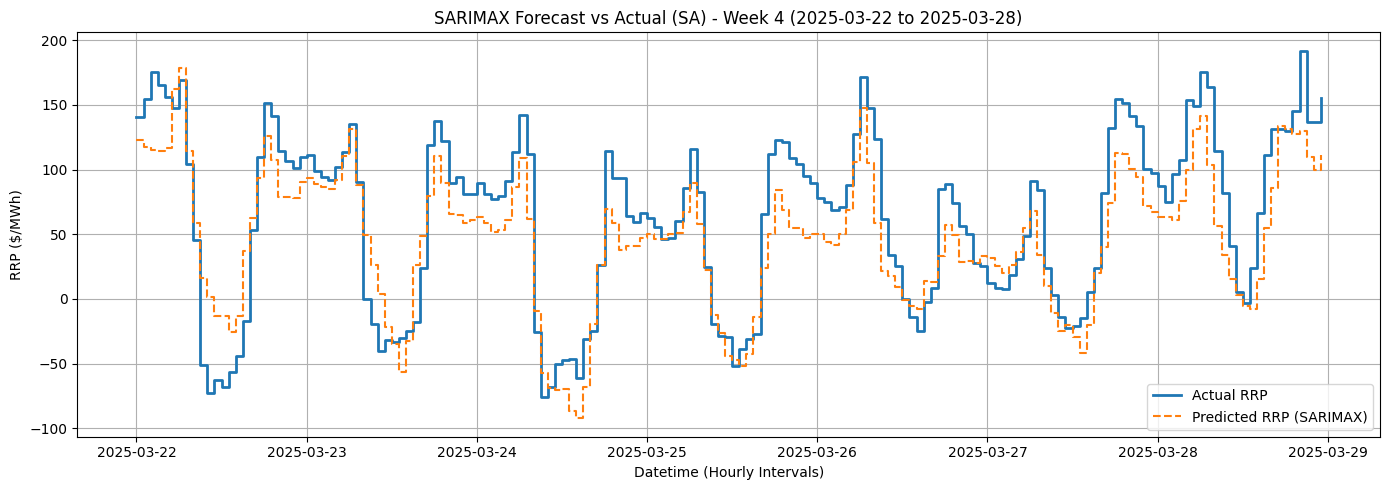


Combined forecast CSV saved to: ./sarimax_outputs/SA_asinh_RRP\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/SA_asinh_RRP\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End        MAE      rMAE       RMSE     SMAPE  \
0  Week 1  2025-03-01  2025-03-07  30.485601  0.410728  44.537886  0.640712   
1  Week 2  2025-03-08  2025-03-14  32.870758  0.340722  44.524547  0.383738   
2  Week 3  2025-03-15  2025-03-21  29.203120  0.405707  39.547804  0.540053   
3  Week 4  2025-03-22  2025-03-28  26.254787  0.506961  31.489257  0.518222   

         MBE  
0  -0.619731  
1  -2.518920  
2  -3.564251  
3 -16.378315  

Processing forecast for Week 1 (TAS)...
MAE:  32.28 $/MWh
Naive MAE: 44.06 $/MWh
RMAE: 0.73
RMSE: 44.50 $/MWh
SMAPE: 43.55%
MBE:  19.84 $/MWh


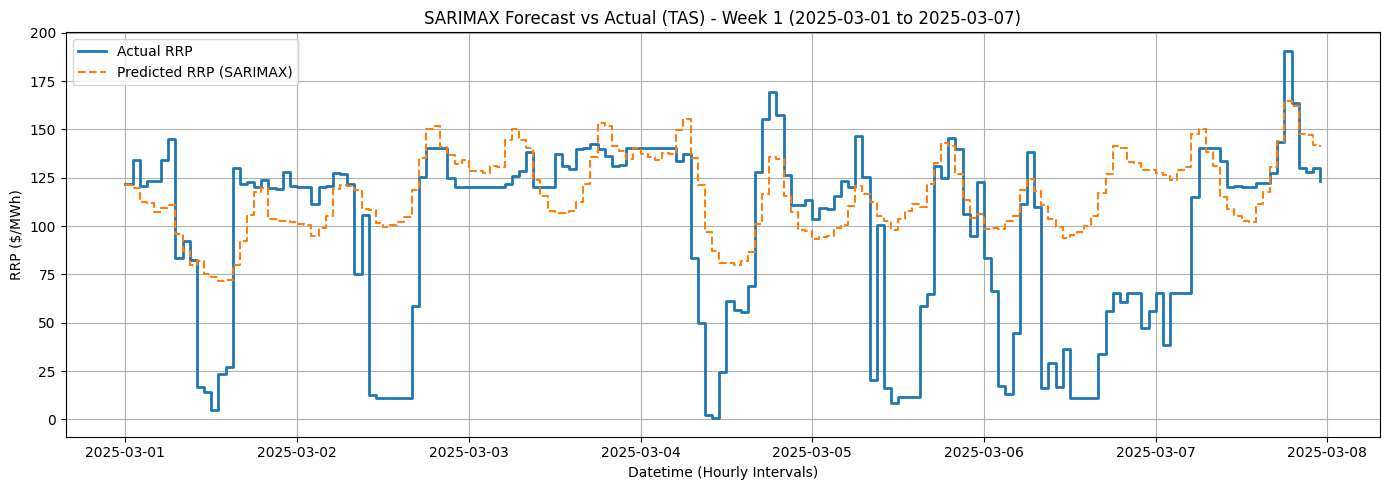


Processing forecast for Week 2 (TAS)...
MAE:  27.53 $/MWh
Naive MAE: 38.55 $/MWh
RMAE: 0.71
RMSE: 34.78 $/MWh
SMAPE: 26.86%
MBE:  -22.55 $/MWh


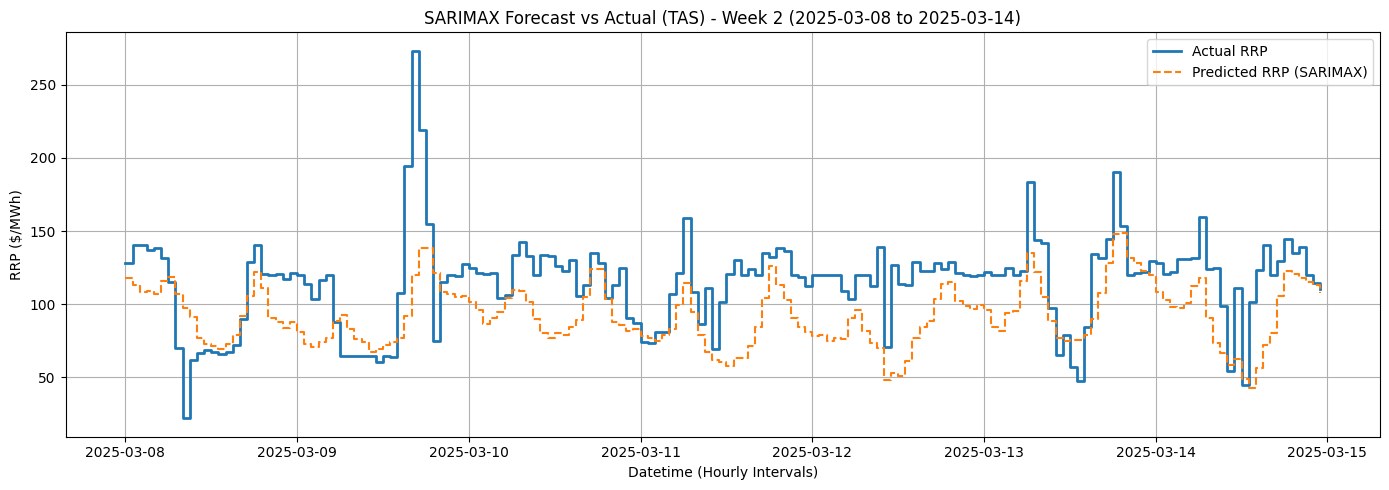


Processing forecast for Week 3 (TAS)...
MAE:  20.02 $/MWh
Naive MAE: 32.49 $/MWh
RMAE: 0.62
RMSE: 26.57 $/MWh
SMAPE: 26.71%
MBE:  9.80 $/MWh


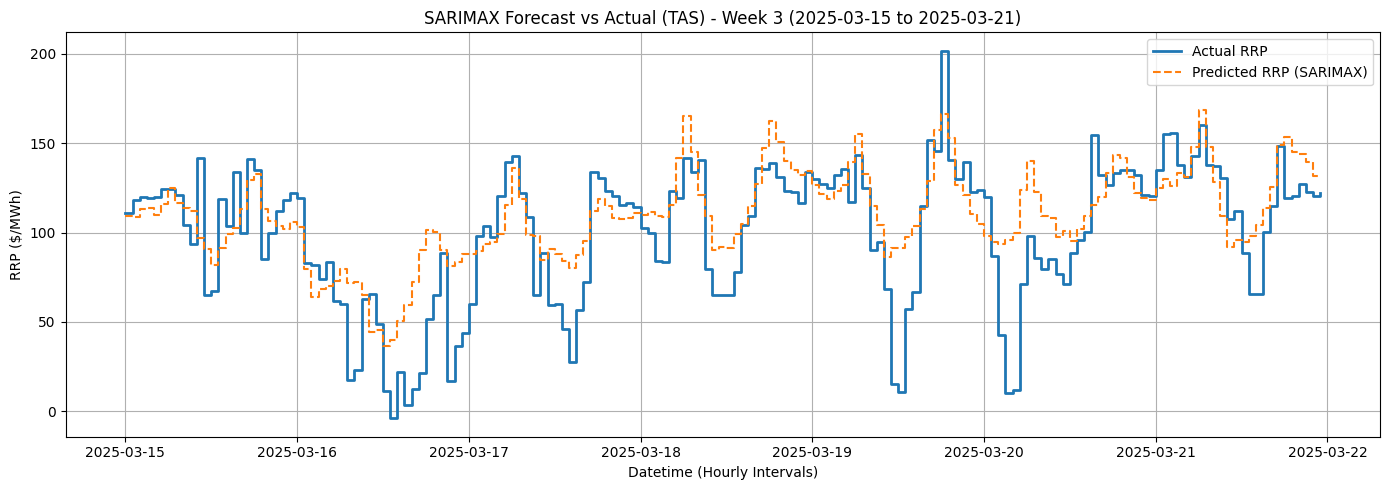


Processing forecast for Week 4 (TAS)...
MAE:  19.05 $/MWh
Naive MAE: 31.88 $/MWh
RMAE: 0.60
RMSE: 25.95 $/MWh
SMAPE: 25.08%
MBE:  2.54 $/MWh


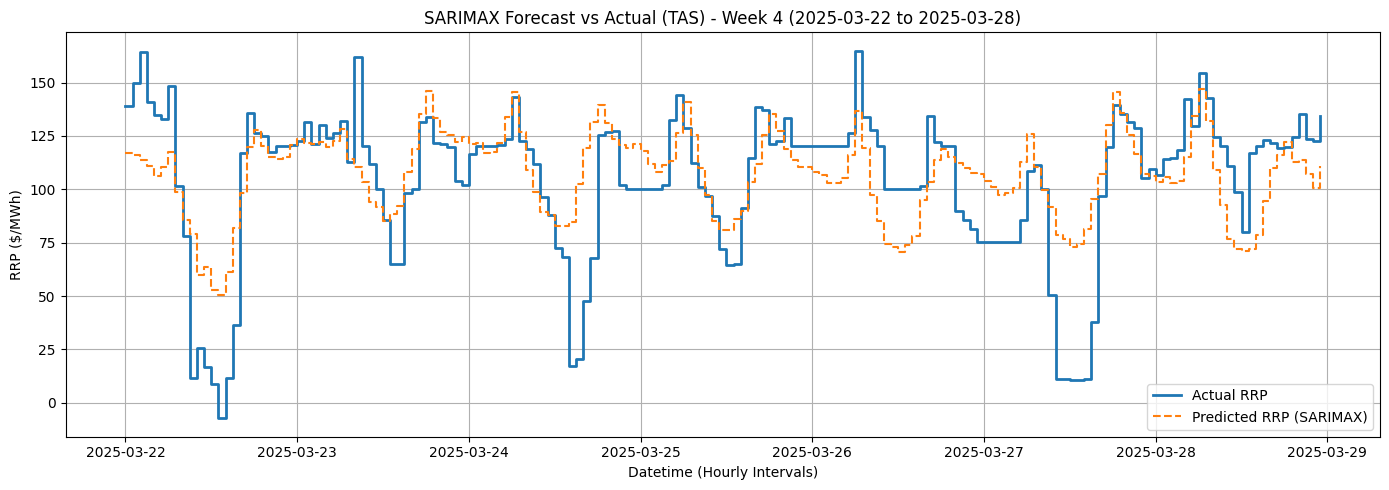


Combined forecast CSV saved to: ./sarimax_outputs/TAS_asinh_RRP\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/TAS_asinh_RRP\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End        MAE      rMAE       RMSE     SMAPE  \
0  Week 1  2025-03-01  2025-03-07  32.280231  0.732574  44.503256  0.435522   
1  Week 2  2025-03-08  2025-03-14  27.531500  0.714157  34.779456  0.268637   
2  Week 3  2025-03-15  2025-03-21  20.023561  0.616371  26.571278  0.267071   
3  Week 4  2025-03-22  2025-03-28  19.051689  0.597687  25.954059  0.250828   

         MBE  
0  19.843009  
1 -22.554534  
2   9.798997  
3   2.535418  


In [2]:
for state in ["VIC", "NSW", "QLD", "SA", "TAS"]:
    run_sarimax_pipeline(state)

In [ ]:
# Run for specific state
if __name__ == "__main__":
    run_sarimax_pipeline("VIC")


Processing forecast for Week 1 (VIC)...
MAE:  36.74 $/MWh
Naive MAE: 58.32 $/MWh
RMAE: 0.63
RMSE: 44.59 $/MWh
SMAPE: 84.46%
MBE:  27.10 $/MWh


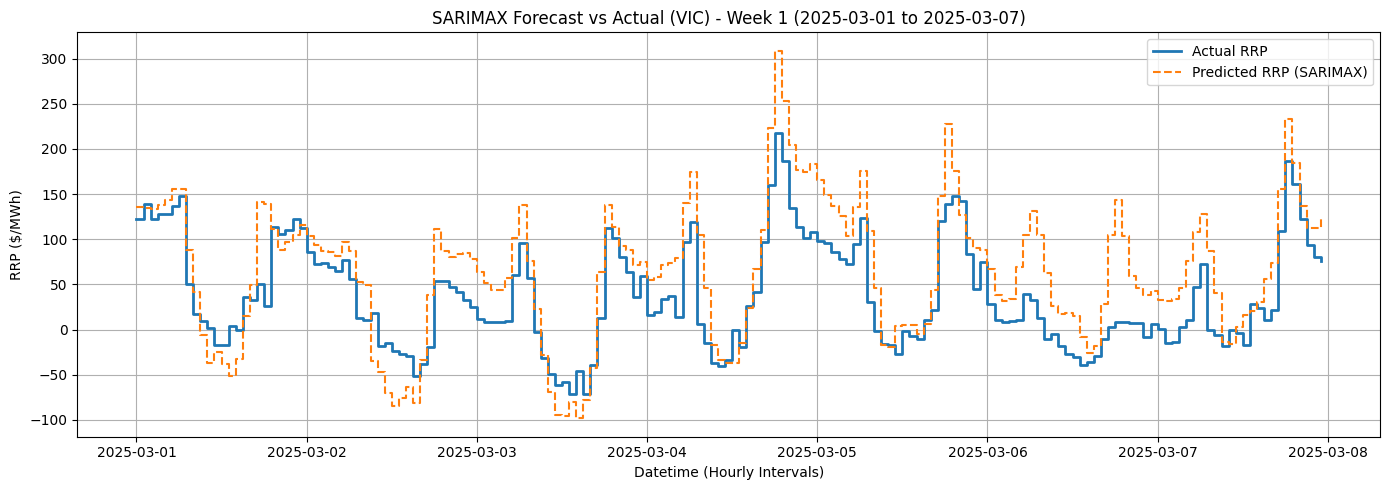


Processing forecast for Week 2 (VIC)...
MAE:  37.36 $/MWh
Naive MAE: 65.95 $/MWh
RMAE: 0.57
RMSE: 47.83 $/MWh
SMAPE: 49.32%
MBE:  14.92 $/MWh


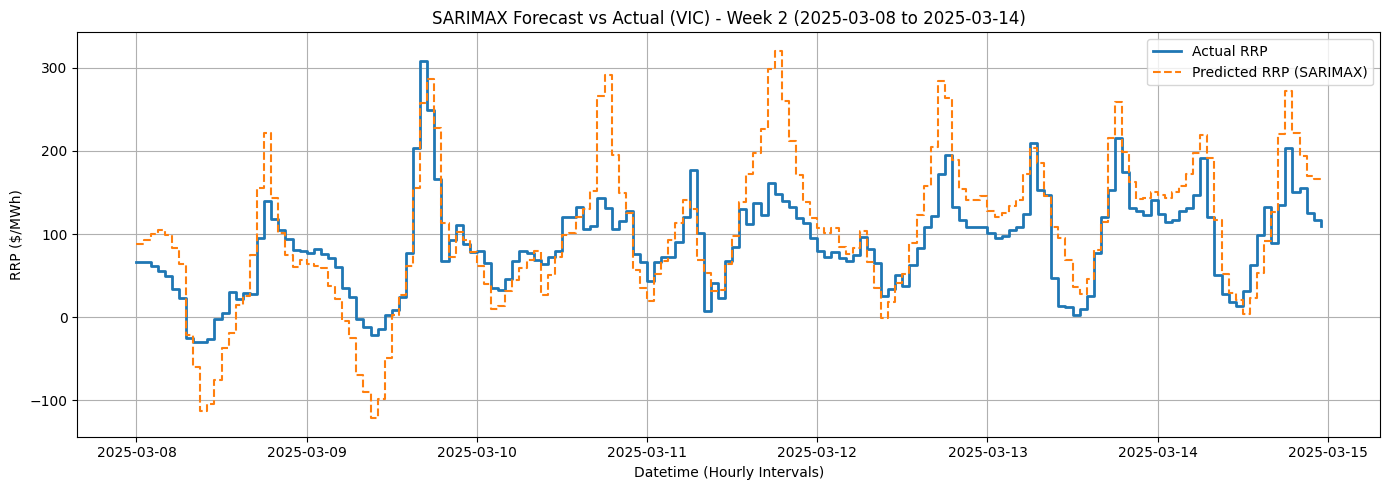


Processing forecast for Week 3 (VIC)...
MAE:  29.76 $/MWh
Naive MAE: 46.74 $/MWh
RMAE: 0.64
RMSE: 37.73 $/MWh
SMAPE: 68.58%
MBE:  -2.31 $/MWh


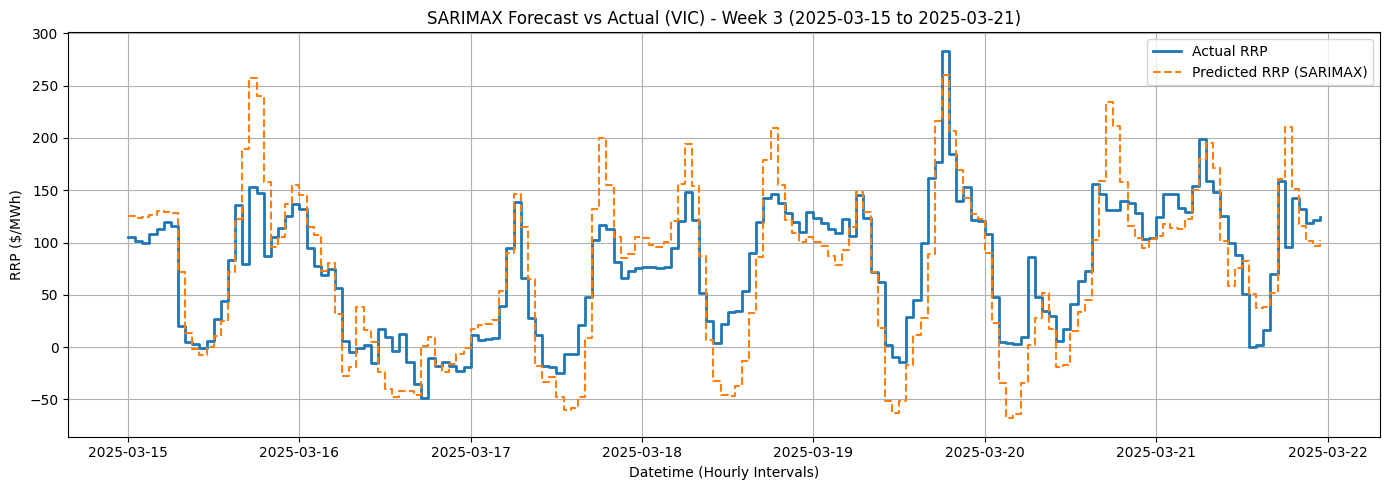


Processing forecast for Week 4 (VIC)...
MAE:  25.62 $/MWh
Naive MAE: 43.67 $/MWh
RMAE: 0.59
RMSE: 33.84 $/MWh
SMAPE: 56.58%
MBE:  -12.18 $/MWh


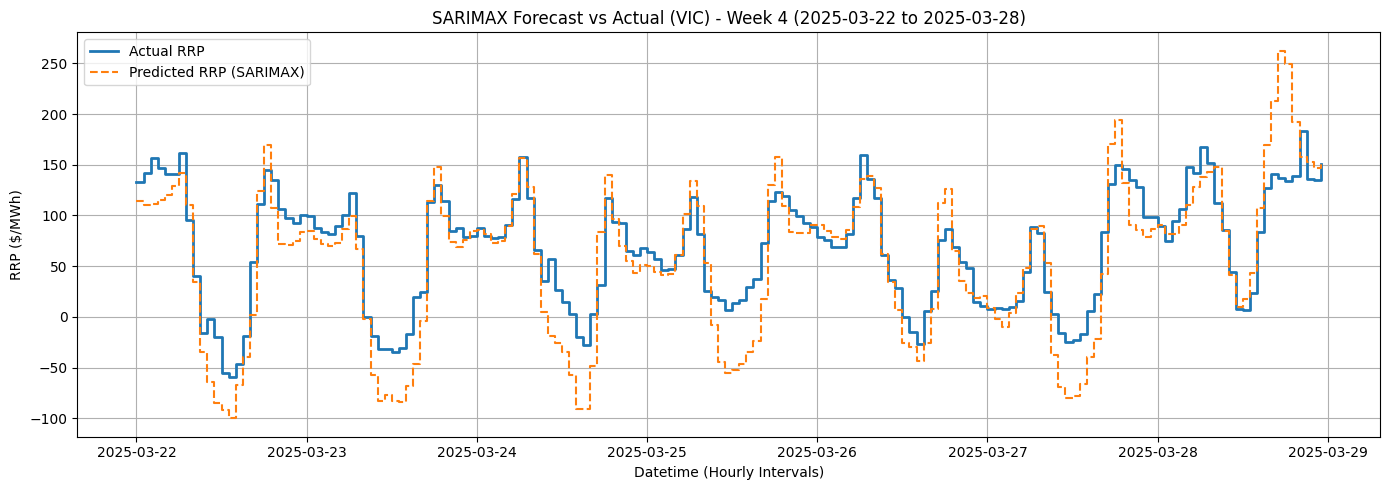


Combined forecast CSV saved to: ./sarimax_outputs/VIC_RRP_RAW\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/VIC_RRP_RAW\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End        MAE      rMAE       RMSE     SMAPE  \
0  Week 1  2025-03-01  2025-03-07  36.739953  0.629940  44.585432  0.844622   
1  Week 2  2025-03-08  2025-03-14  37.356923  0.566416  47.833169  0.493190   
2  Week 3  2025-03-15  2025-03-21  29.755290  0.636653  37.731086  0.685757   
3  Week 4  2025-03-22  2025-03-28  25.623989  0.586805  33.840141  0.565802   

         MBE  
0  27.095657  
1  14.915461  
2  -2.305407  
3 -12.181691  

Processing forecast for Week 1 (NSW)...
MAE:  55.22 $/MWh
Naive MAE: 37.34 $/MWh
RMAE: 1.48
RMSE: 75.28 $/MWh
SMAPE: 95.45%
MBE:  -2.10 $/MWh


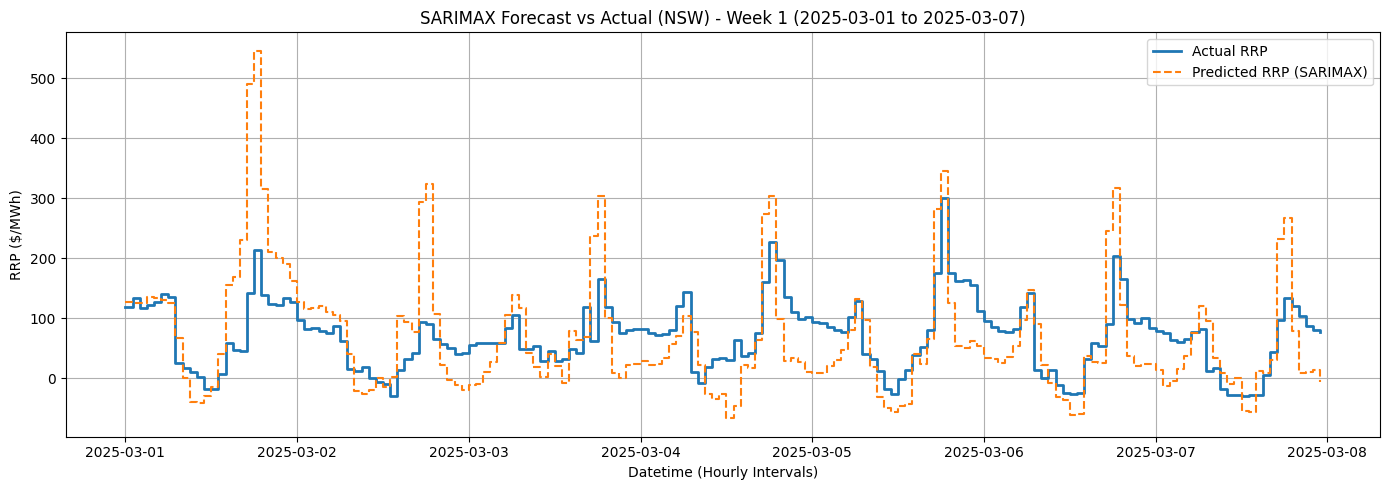


Processing forecast for Week 2 (NSW)...
MAE:  65.49 $/MWh
Naive MAE: 46.15 $/MWh
RMAE: 1.42
RMSE: 116.55 $/MWh
SMAPE: 73.40%
MBE:  24.12 $/MWh


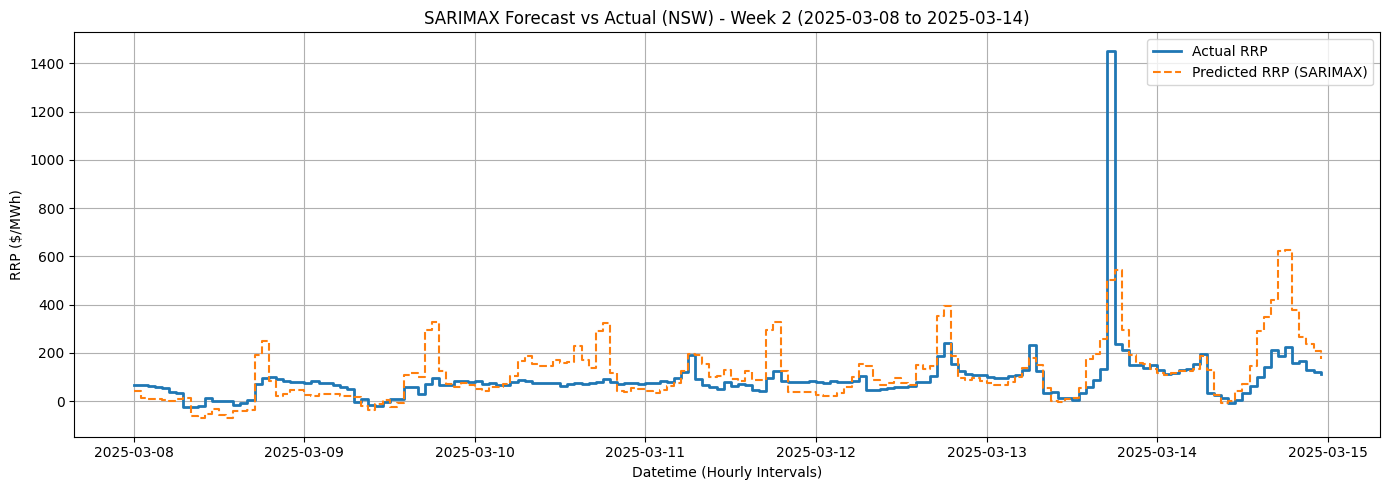


Processing forecast for Week 3 (NSW)...
MAE:  119.35 $/MWh
Naive MAE: 85.81 $/MWh
RMAE: 1.39
RMSE: 310.27 $/MWh
SMAPE: 90.30%
MBE:  -15.25 $/MWh


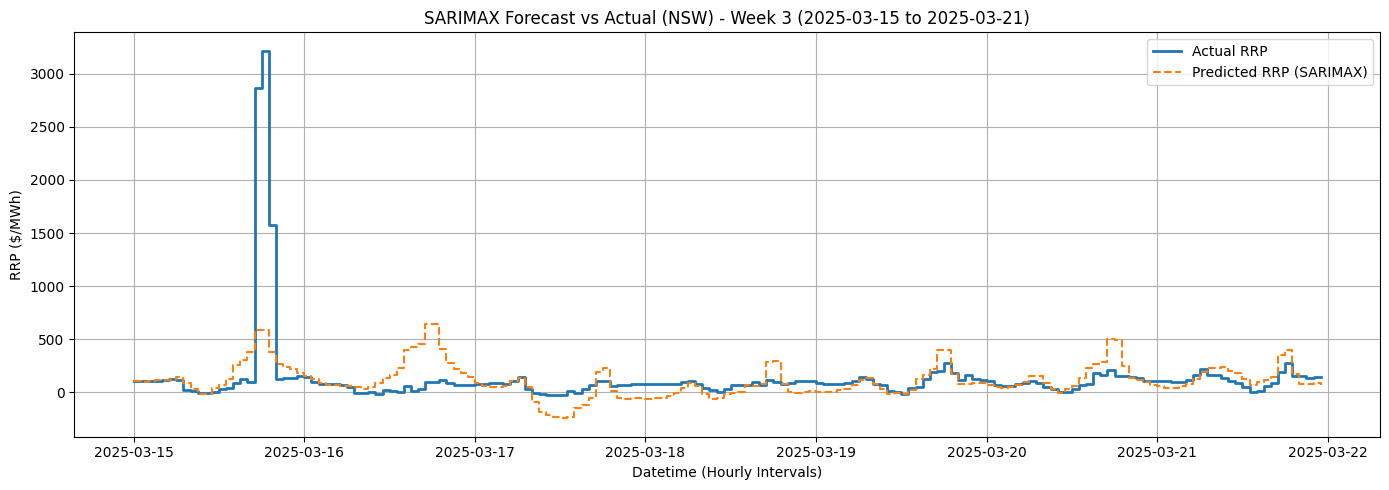


Processing forecast for Week 4 (NSW)...
MAE:  58.06 $/MWh
Naive MAE: 81.38 $/MWh
RMAE: 0.71
RMSE: 76.22 $/MWh
SMAPE: 72.21%
MBE:  2.73 $/MWh


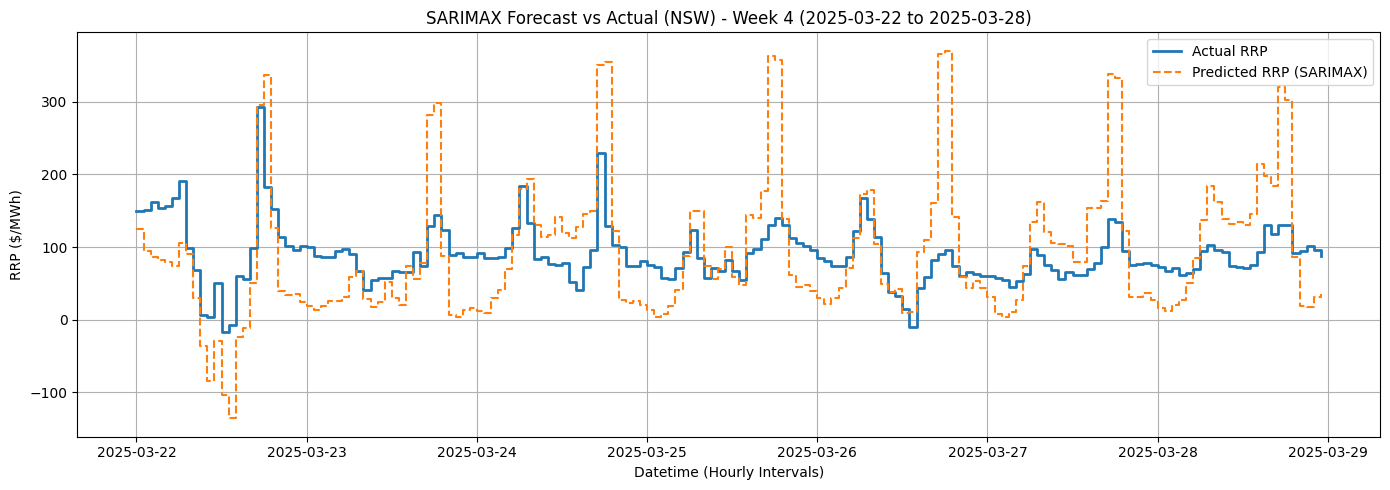


Combined forecast CSV saved to: ./sarimax_outputs/NSW_RRP_RAW\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/NSW_RRP_RAW\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End         MAE      rMAE        RMSE     SMAPE  \
0  Week 1  2025-03-01  2025-03-07   55.217245  1.478779   75.278057  0.954531   
1  Week 2  2025-03-08  2025-03-14   65.485079  1.418925  116.554224  0.733976   
2  Week 3  2025-03-15  2025-03-21  119.347068  1.390906  310.272732  0.903045   
3  Week 4  2025-03-22  2025-03-28   58.055190  0.713350   76.224076  0.722136   

         MBE  
0  -2.104606  
1  24.116888  
2 -15.252100  
3   2.734387  

Processing forecast for Week 1 (QLD)...
MAE:  42.34 $/MWh
Naive MAE: 28.41 $/MWh
RMAE: 1.49
RMSE: 63.81 $/MWh
SMAPE: 68.74%
MBE:  -1.10 $/MWh


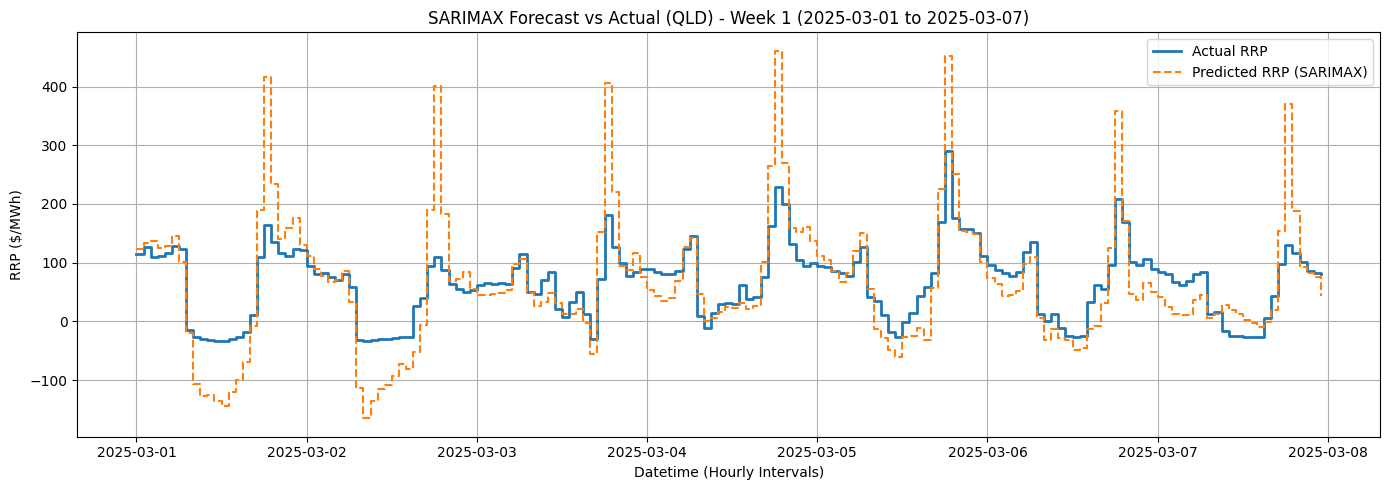


Processing forecast for Week 2 (QLD)...
MAE:  40.86 $/MWh
Naive MAE: 35.86 $/MWh
RMAE: 1.14
RMSE: 94.48 $/MWh
SMAPE: 70.40%
MBE:  -4.69 $/MWh


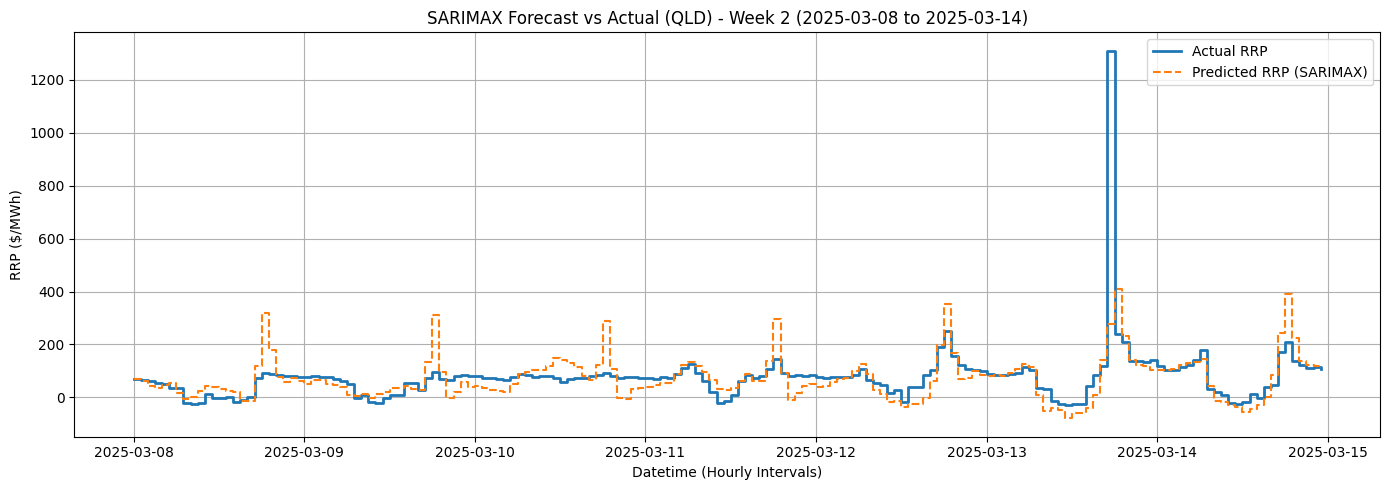


Processing forecast for Week 3 (QLD)...
MAE:  37.35 $/MWh
Naive MAE: 36.36 $/MWh
RMAE: 1.03
RMSE: 58.91 $/MWh
SMAPE: 57.94%
MBE:  -0.95 $/MWh


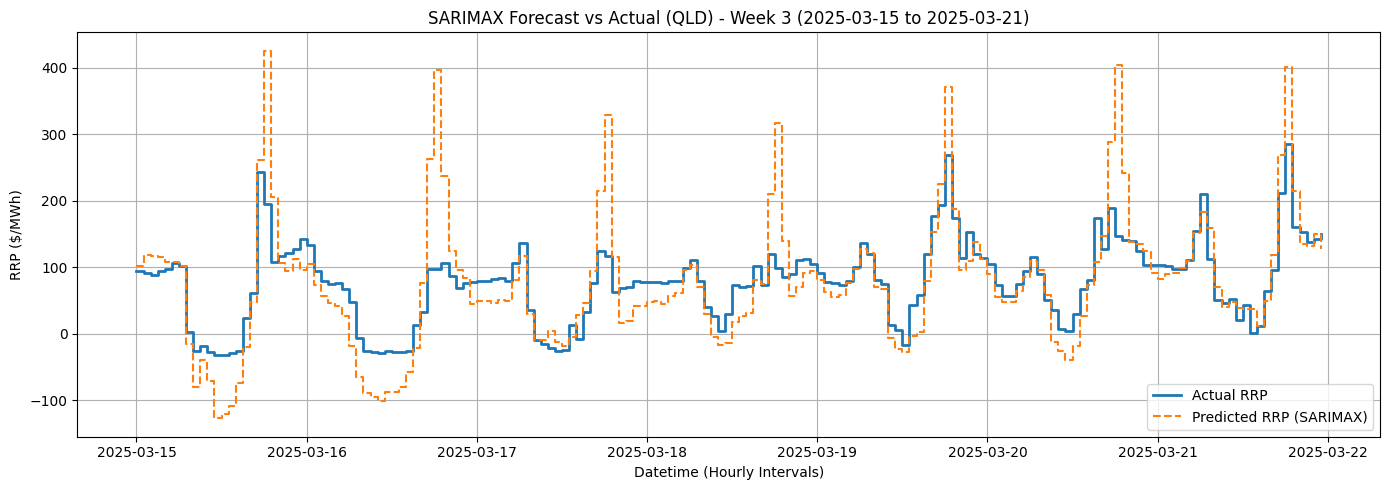


Processing forecast for Week 4 (QLD)...
MAE:  35.02 $/MWh
Naive MAE: 42.57 $/MWh
RMAE: 0.82
RMSE: 52.36 $/MWh
SMAPE: 47.76%
MBE:  -4.96 $/MWh


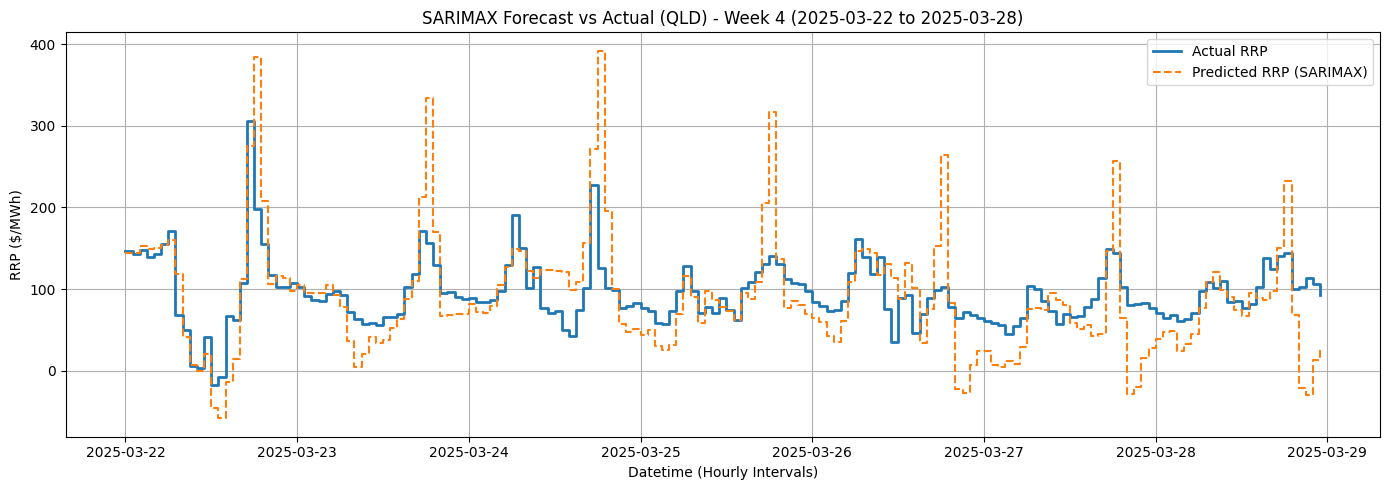


Combined forecast CSV saved to: ./sarimax_outputs/QLD_RRP_RAW\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/QLD_RRP_RAW\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End        MAE      rMAE       RMSE     SMAPE  \
0  Week 1  2025-03-01  2025-03-07  42.340084  1.490076  63.809018  0.687432   
1  Week 2  2025-03-08  2025-03-14  40.863308  1.139549  94.482728  0.704002   
2  Week 3  2025-03-15  2025-03-21  37.350245  1.027295  58.910898  0.579435   
3  Week 4  2025-03-22  2025-03-28  35.023048  0.822737  52.363862  0.477627   

        MBE  
0 -1.103051  
1 -4.690768  
2 -0.946937  
3 -4.957109  

Processing forecast for Week 1 (SA)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  53.90 $/MWh
Naive MAE: 74.22 $/MWh
RMAE: 0.73
RMSE: 71.13 $/MWh
SMAPE: 83.94%
MBE:  23.90 $/MWh


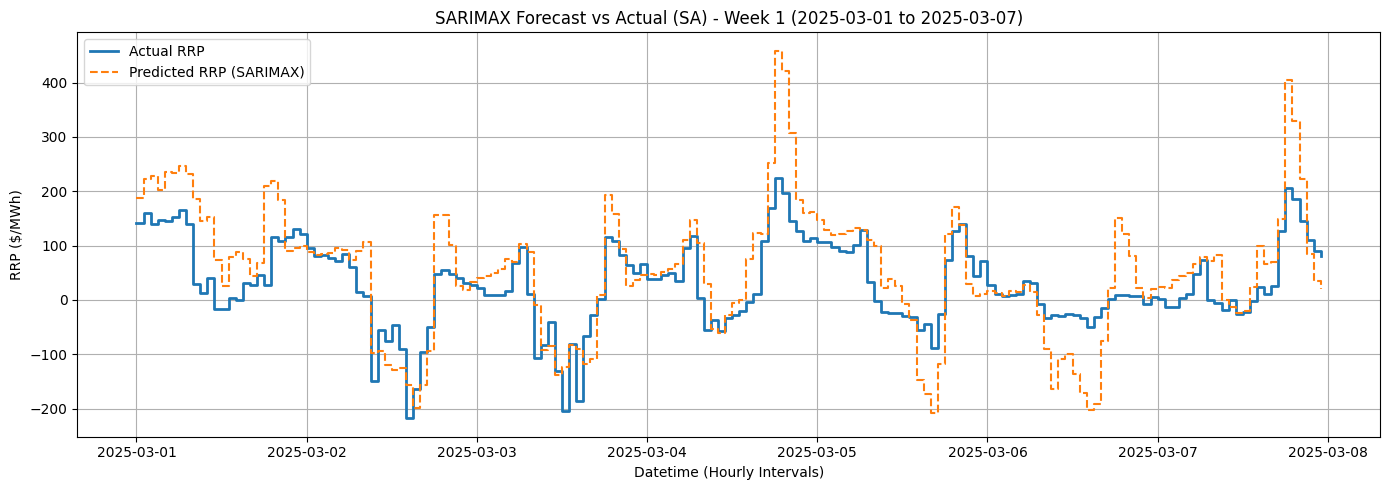


Processing forecast for Week 2 (SA)...
MAE:  80.45 $/MWh
Naive MAE: 96.47 $/MWh
RMAE: 0.83
RMSE: 107.79 $/MWh
SMAPE: 63.52%
MBE:  61.45 $/MWh


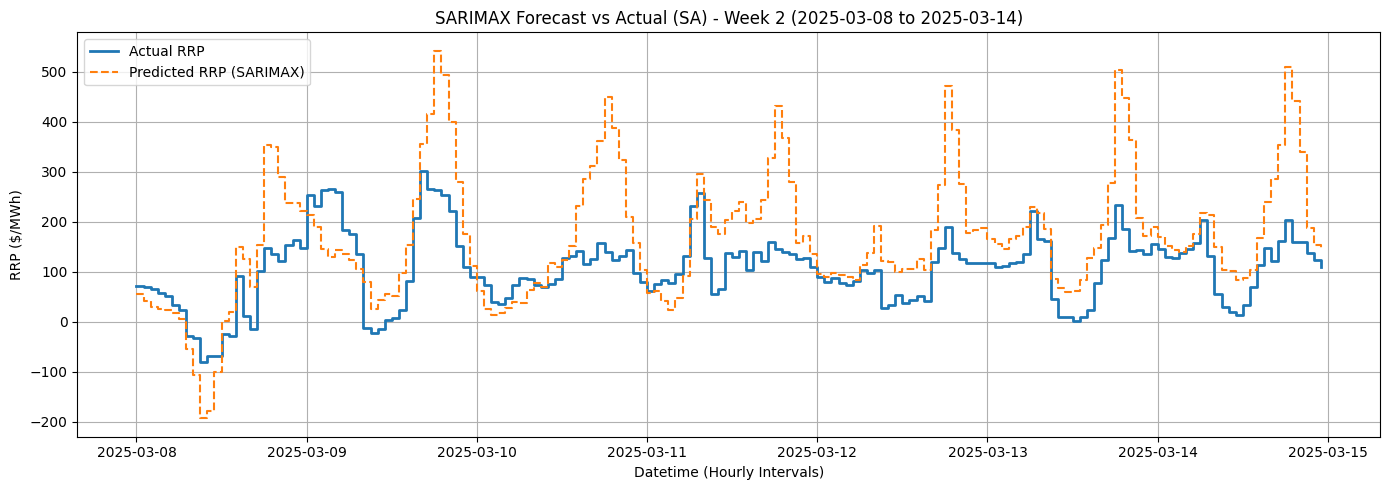


Processing forecast for Week 3 (SA)...
MAE:  62.95 $/MWh
Naive MAE: 71.98 $/MWh
RMAE: 0.87
RMSE: 85.65 $/MWh
SMAPE: 70.33%
MBE:  18.79 $/MWh


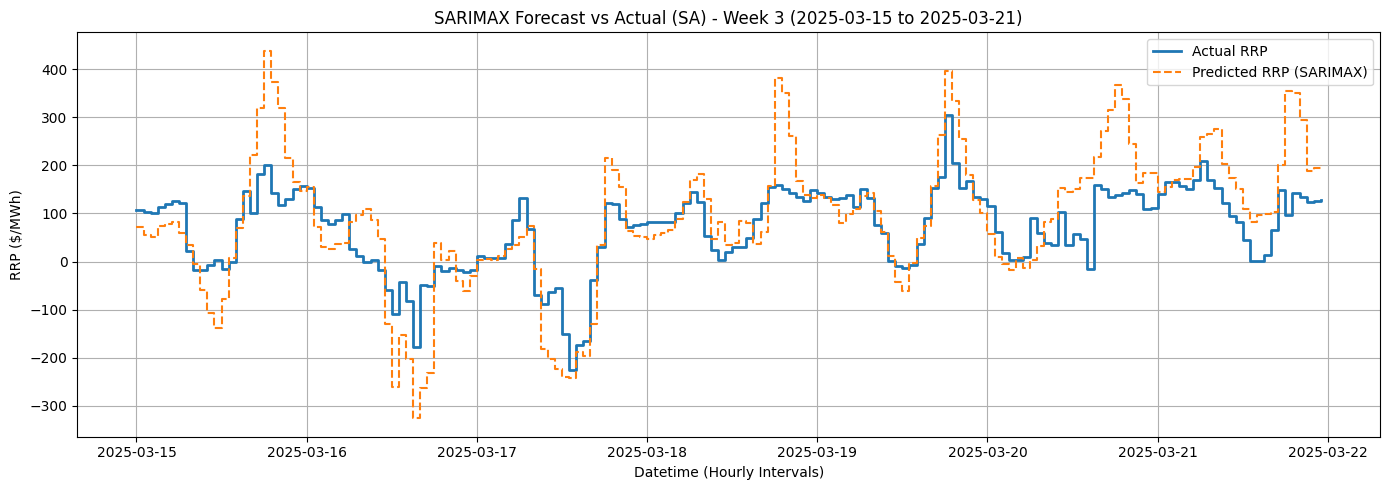


Processing forecast for Week 4 (SA)...
MAE:  43.68 $/MWh
Naive MAE: 51.79 $/MWh
RMAE: 0.84
RMSE: 52.83 $/MWh
SMAPE: 86.01%
MBE:  -16.09 $/MWh


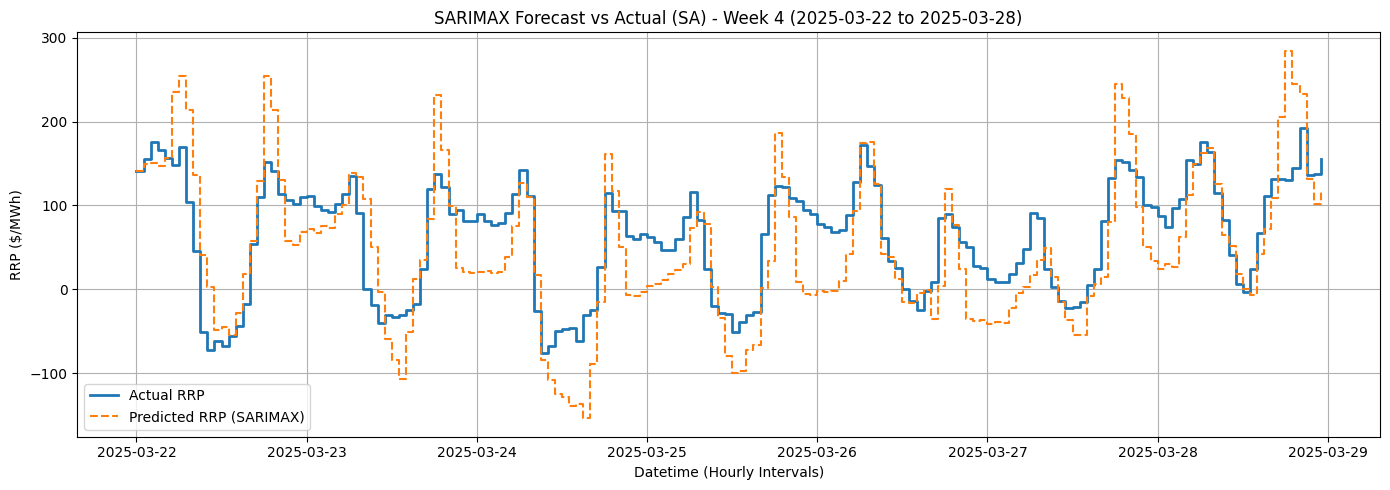


Combined forecast CSV saved to: ./sarimax_outputs/SA_RRP_RAW\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/SA_RRP_RAW\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End        MAE      rMAE        RMSE     SMAPE  \
0  Week 1  2025-03-01  2025-03-07  53.903272  0.726230   71.131721  0.839354   
1  Week 2  2025-03-08  2025-03-14  80.449472  0.833898  107.794301  0.635232   
2  Week 3  2025-03-15  2025-03-21  62.953054  0.874581   85.654359  0.703328   
3  Week 4  2025-03-22  2025-03-28  43.681819  0.843465   52.828138  0.860061   

         MBE  
0  23.904879  
1  61.452152  
2  18.794293  
3 -16.093609  

Processing forecast for Week 1 (TAS)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  33.61 $/MWh
Naive MAE: 44.06 $/MWh
RMAE: 0.76
RMSE: 42.93 $/MWh
SMAPE: 45.95%
MBE:  13.17 $/MWh


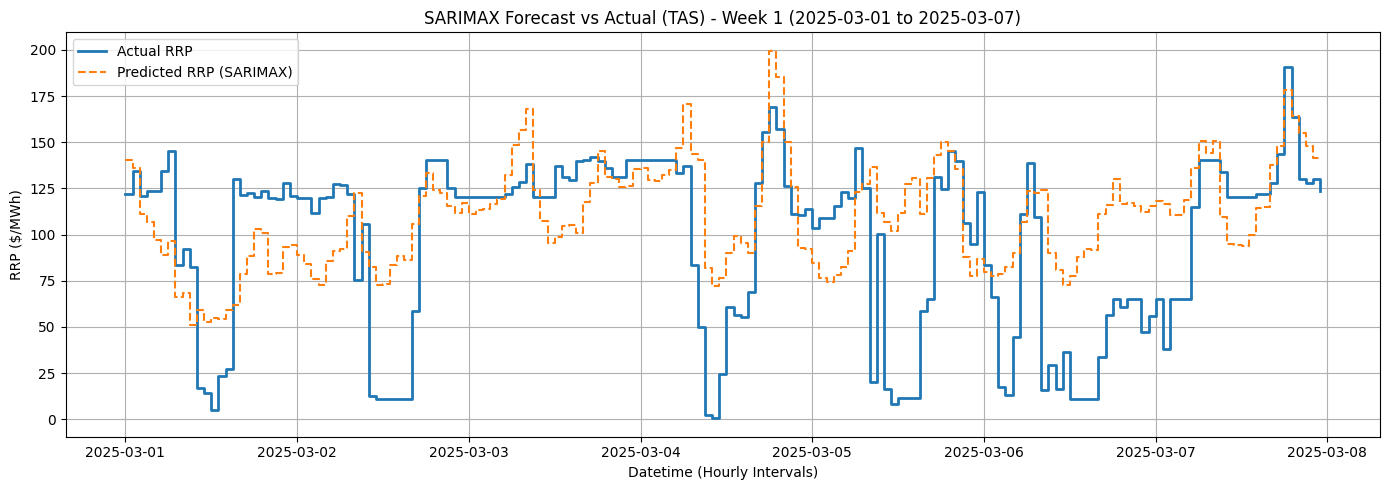


Processing forecast for Week 2 (TAS)...
MAE:  27.80 $/MWh
Naive MAE: 38.55 $/MWh
RMAE: 0.72
RMSE: 33.53 $/MWh
SMAPE: 27.57%
MBE:  -11.16 $/MWh


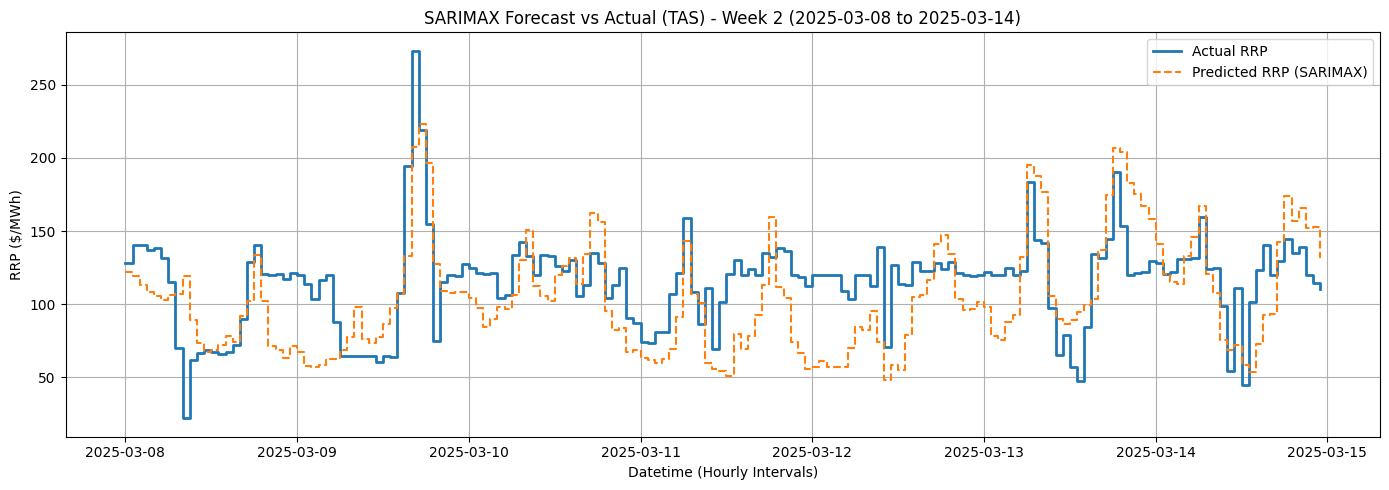


Processing forecast for Week 3 (TAS)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  25.68 $/MWh
Naive MAE: 32.49 $/MWh
RMAE: 0.79
RMSE: 30.61 $/MWh
SMAPE: 31.88%
MBE:  9.31 $/MWh


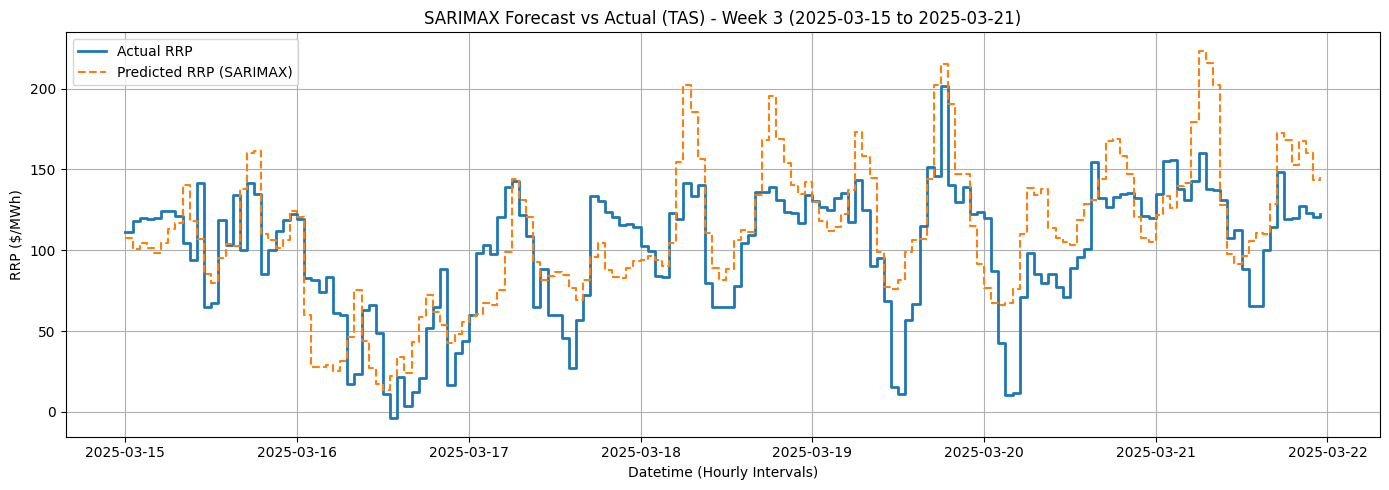


Processing forecast for Week 4 (TAS)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  23.94 $/MWh
Naive MAE: 31.88 $/MWh
RMAE: 0.75
RMSE: 29.11 $/MWh
SMAPE: 30.03%
MBE:  -4.85 $/MWh


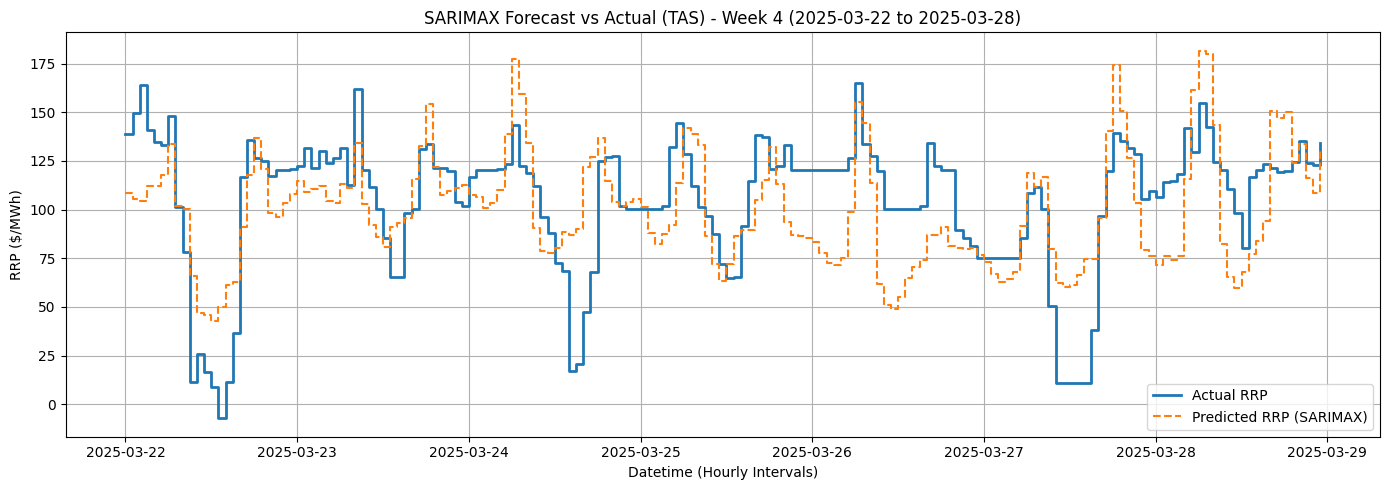


Combined forecast CSV saved to: ./sarimax_outputs/TAS_RRP_RAW\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/TAS_RRP_RAW\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End        MAE      rMAE       RMSE     SMAPE  \
0  Week 1  2025-03-01  2025-03-07  33.608803  0.762725  42.925526  0.459513   
1  Week 2  2025-03-08  2025-03-14  27.797013  0.721044  33.529036  0.275743   
2  Week 3  2025-03-15  2025-03-21  25.677138  0.790400  30.612823  0.318828   
3  Week 4  2025-03-22  2025-03-28  23.937720  0.750971  29.109764  0.300264   

         MBE  
0  13.169034  
1 -11.162178  
2   9.308722  
3  -4.848861  


In [13]:
for state in ["VIC", "NSW", "QLD", "SA", "TAS"]:
    run_sarimax_pipeline(state)


Processing forecast for Week 1 (QLD)...
MAE:  42.32 $/MWh
RMSE: 63.92 $/MWh
MAPE: 170.48%
MBE:  -1.31 $/MWh


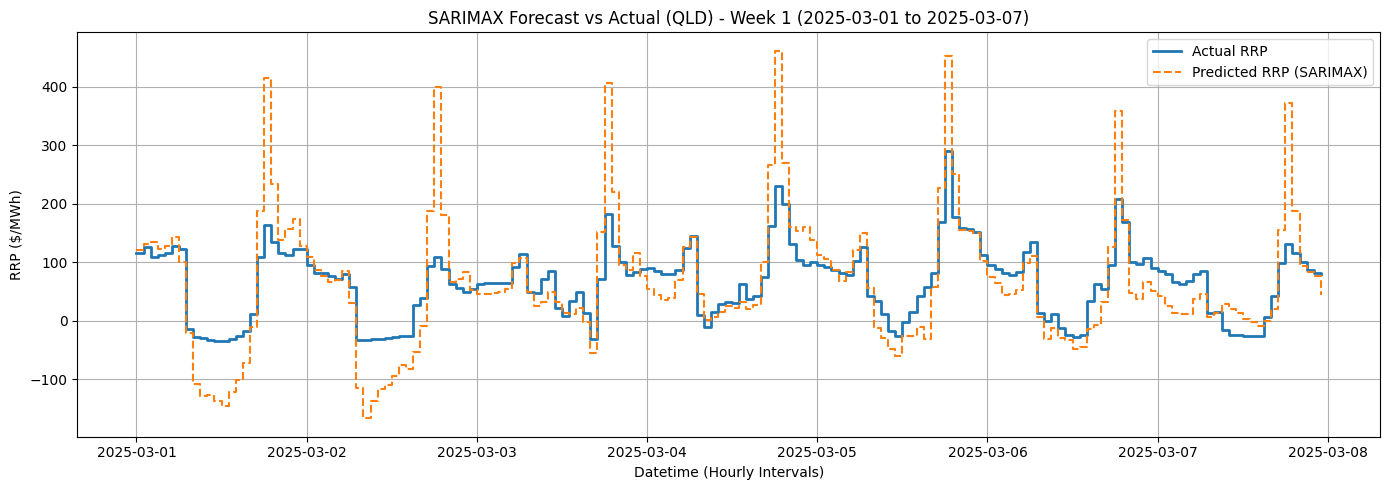


Processing forecast for Week 2 (QLD)...
MAE:  40.82 $/MWh
RMSE: 94.36 $/MWh
MAPE: 185.31%
MBE:  -5.03 $/MWh


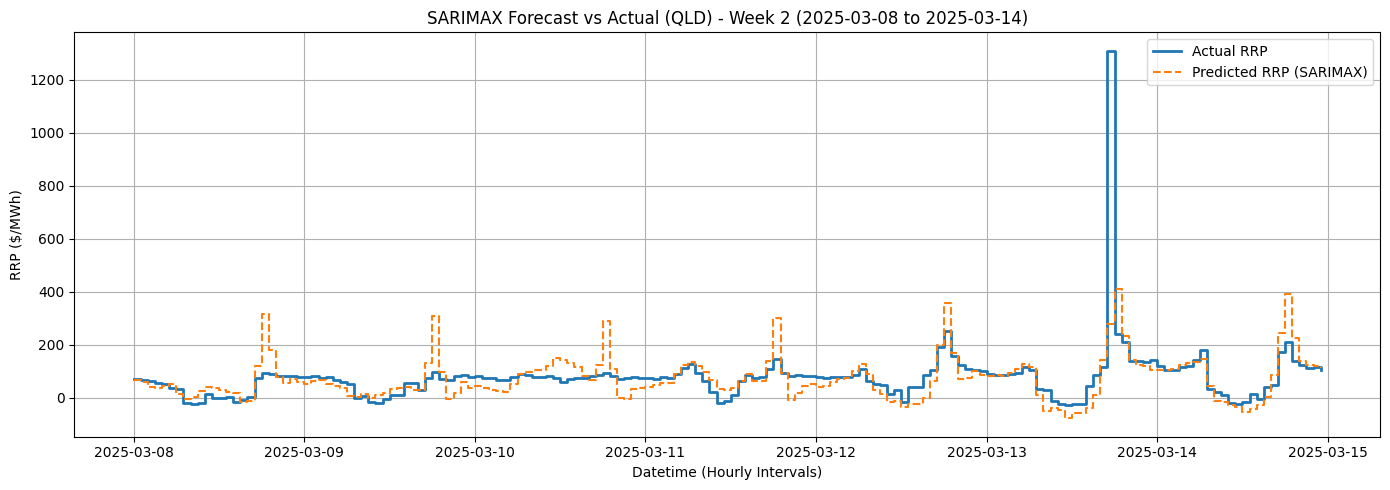


Processing forecast for Week 3 (QLD)...


c:\Users\Srira\repos\nem-epf-thesis\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE:  37.38 $/MWh
RMSE: 58.95 $/MWh
MAPE: 129.66%
MBE:  -1.13 $/MWh


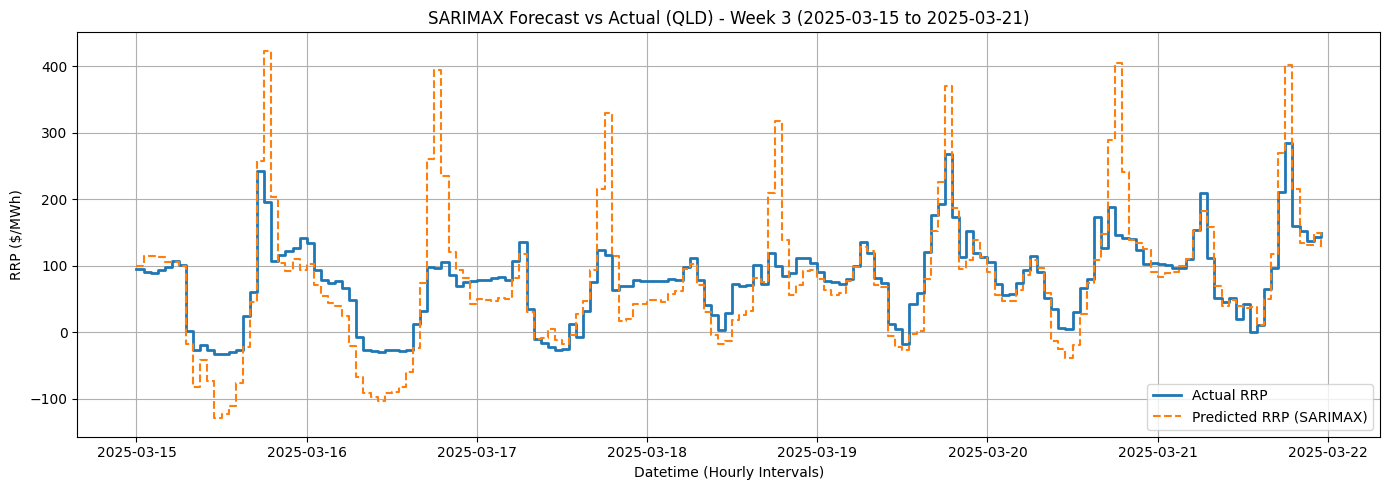


Processing forecast for Week 4 (QLD)...
MAE:  34.92 $/MWh
RMSE: 52.25 $/MWh
MAPE: 46.31%
MBE:  -4.96 $/MWh


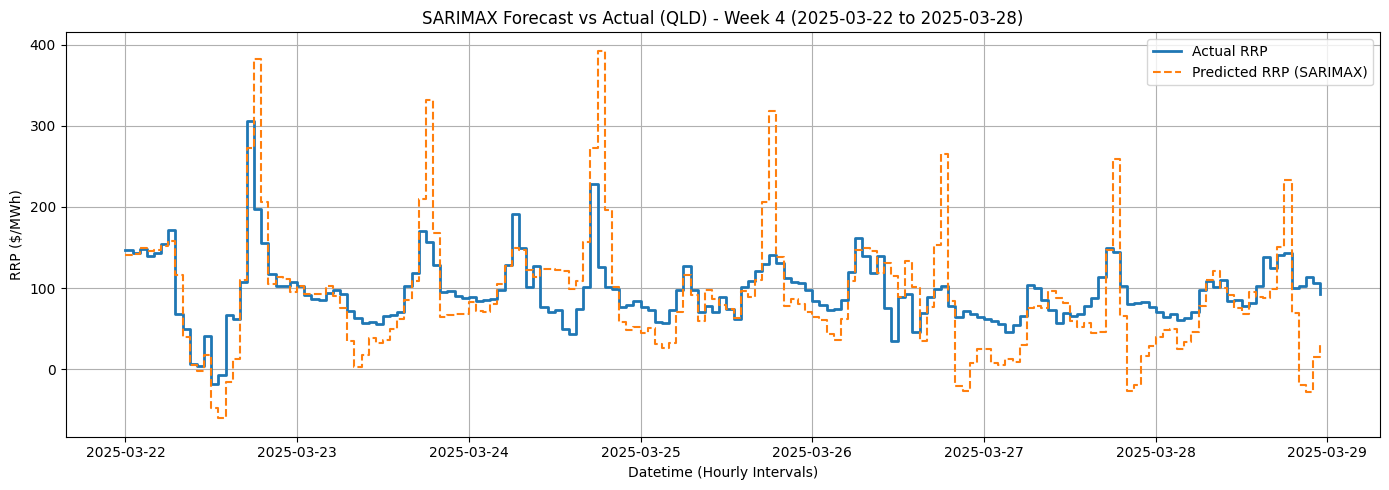


Combined forecast CSV saved to: ./sarimax_outputs/QLD_RRP_RAW\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/QLD_RRP_RAW\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End        MAE       RMSE    MAPE (%)       MBE
0  Week 1  2025-03-01  2025-03-07  42.318922  63.918581  170.482437 -1.310426
1  Week 2  2025-03-08  2025-03-14  40.816726  94.362040  185.306718 -5.029733
2  Week 3  2025-03-15  2025-03-21  37.377103  58.945760  129.655858 -1.129356
3  Week 4  2025-03-22  2025-03-28  34.920522  52.253663   46.313982 -4.959188


In [62]:
run_sarimax_pipeline("QLD")


Processing forecast for Week 1 (TAS)...
MAE:  33.71 $/MWh
RMSE: 43.32 $/MWh
MAPE: 218.01%
MBE:  13.27 $/MWh


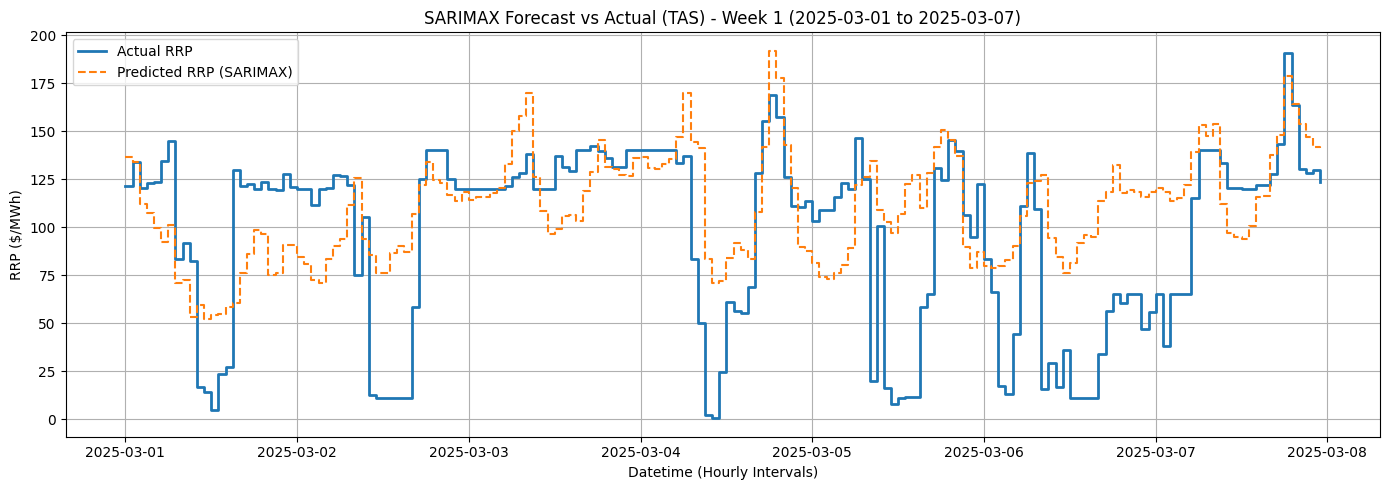


Processing forecast for Week 2 (TAS)...
MAE:  27.86 $/MWh
RMSE: 33.64 $/MWh
MAPE: 26.97%
MBE:  -11.68 $/MWh


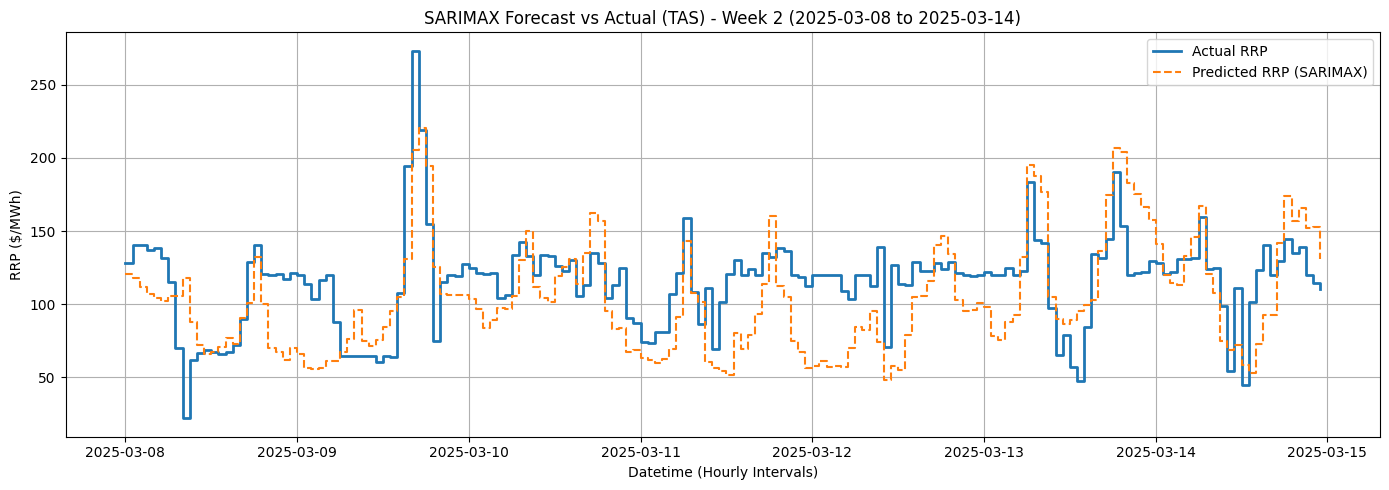


Processing forecast for Week 3 (TAS)...
MAE:  26.49 $/MWh
RMSE: 31.92 $/MWh
MAPE: 42.80%
MBE:  5.66 $/MWh


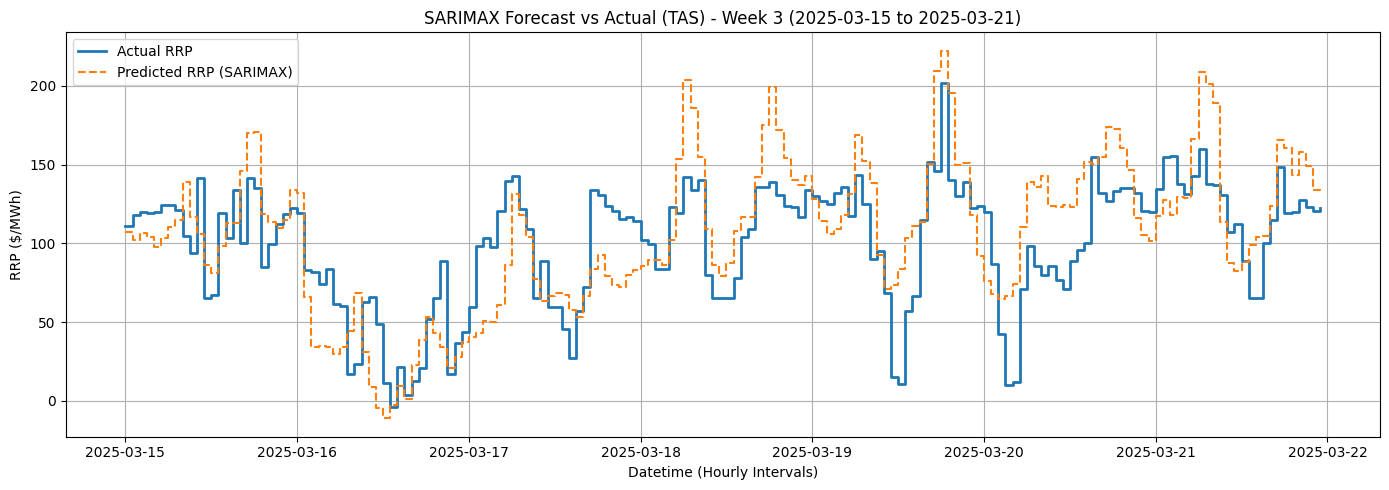


Processing forecast for Week 4 (TAS)...
MAE:  22.16 $/MWh
RMSE: 27.59 $/MWh
MAPE: 52.08%
MBE:  0.25 $/MWh


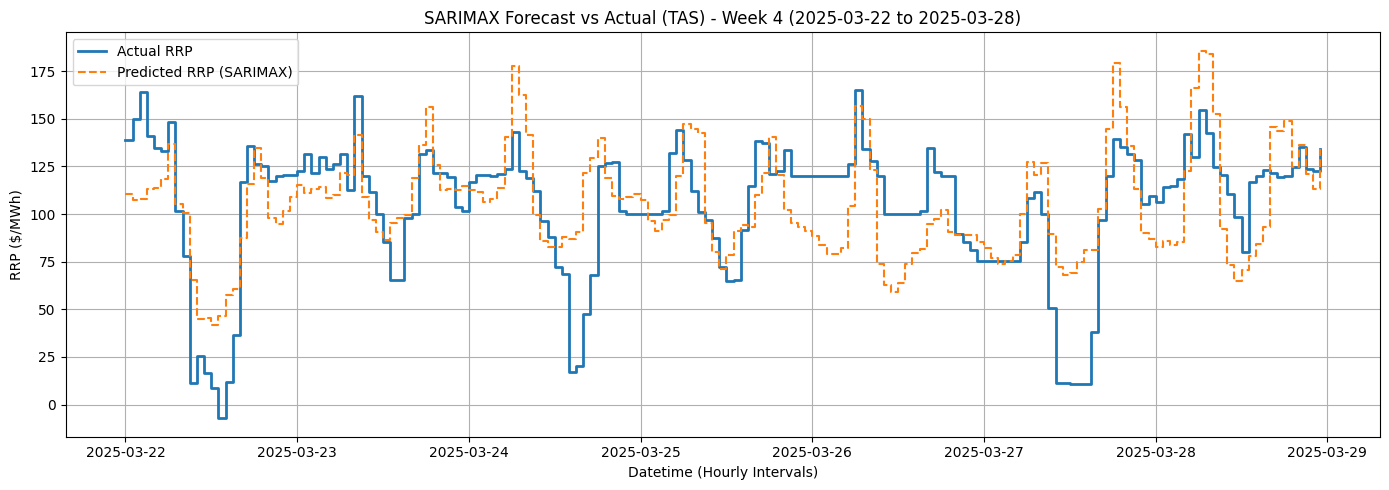


Combined forecast CSV saved to: ./sarimax_outputs/TAS_RRP_RAW\sarimax_combined_forecasts.csv
Metrics summary CSV saved to: ./sarimax_outputs/TAS_RRP_RAW\sarimax_weekly_metrics.csv

Weekly Metrics Summary:
      Week       Start         End        MAE       RMSE    MAPE (%)        MBE
0  Week 1  2025-03-01  2025-03-07  33.710466  43.320802  218.013889  13.274560
1  Week 2  2025-03-08  2025-03-14  27.859593  33.642418   26.974762 -11.681112
2  Week 3  2025-03-15  2025-03-21  26.494029  31.915333   42.801851   5.661693
3  Week 4  2025-03-22  2025-03-28  22.158167  27.586530   52.082409   0.245960


In [63]:
run_sarimax_pipeline("TAS")